# <center>Traitez les images pour le système embarqué d'une voiture autonome</center>
# <center>Partie II - Segmentation des images</center>

## Préambule 
### 1 - Contexte

### 2 - Chargement des librairies

In [1]:
# Version Python
!python --version

Python 3.12.3


In [62]:
# Librairies pour la manipulation de données
import numpy as np
import random
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.models as models
from tqdm import tqdm
import pickle

# Suppression des warnings
import warnings
warnings.filterwarnings('ignore')

# Librairies pour la visualisation des données
import matplotlib.pyplot as plt
import cv2

# Version bibliothèque partiellement importée
import importlib.metadata

# Version des bibliothèques utilisées
print('\n'.join(f'{m.__name__} - {m.__version__}'
                for m in globals().values()
                if getattr(m, '__version__', None)))
print("matplotlib - ", importlib.metadata.version('matplotlib'))

json - 2.0.9
numpy - 2.2.3
pandas - 2.2.3
torch - 2.6.0+cpu
numpy - 2.2.3
pandas - 2.2.3
torch - 2.6.0+cpu
cv2 - 4.11.0
matplotlib -  3.10.0


### 3 - Lecture des fichiers

In [63]:
# Liste des dossiers à notre disposition
chemin_original = "../Echantillons_redim/Original"
chemin_categorie = "../Echantillons_redim/Image_annote_categorie"
liste_dossiers = os.listdir(chemin_original)
print("Liste des villes présentes dans notre dossier :", liste_dossiers)
print("Nombre de villes présentes :", len(liste_dossiers))

Liste des villes présentes dans notre dossier : ['aachen', 'bochum', 'bremen', 'cologne', 'darmstadt', 'dusseldorf', 'erfurt', 'hamburg', 'hanover', 'jena', 'krefeld', 'monchengladbach', 'strasbourg', 'stuttgart', 'tubingen', 'ulm', 'weimar', 'zurich']
Nombre de villes présentes : 18


Nous avons toujours ici nos 18 villes avec 50 images par ville soit 180 images à notre disposition.

## I - Séparation des données et fonctions communes

### 1 - Séparation des données

In [64]:
# Liste des villes
villes = os.listdir(chemin_original)

# Liste pour stocker les chemins des images et masques
train_images = []
train_masks = []
test_images = []
test_masks = []

# Parcourir chaque ville et diviser les données
for ville in villes:
    images = os.listdir(os.path.join(chemin_original, ville))
    masks = os.listdir(os.path.join(chemin_categorie, ville))

    # Diviser les données en ensembles d'entraînement et de test pour chaque ville
    train_img, test_img, train_msk, test_msk = train_test_split(images, masks, test_size=0.2, random_state=42)

    # Ajouter les chemins complets aux listes
    train_images.extend([os.path.join(chemin_original, ville, img) for img in train_img])
    train_masks.extend([os.path.join(chemin_categorie, ville, msk) for msk in train_msk])
    test_images.extend([os.path.join(chemin_original, ville, img) for img in test_img])
    test_masks.extend([os.path.join(chemin_categorie, ville, msk) for msk in test_msk])

### 2 - Fonctions communes

In [65]:
# Fonction pour remapper les valeurs des masques
def remap_mask_values(mask):
    # Dictionnaire de remappage
    value_map = {
        0: 0,
        14: 1,
        38: 2,
        52: 3,
        75: 4,
        89: 5,
        113: 6,
        128: 7
    }
    # Créer une nouvelle image avec les valeurs remappées
    remapped_mask = np.zeros_like(mask)
    for original_value, new_value in value_map.items():
        remapped_mask[mask == original_value] = new_value
    return remapped_mask

# Transformation personnalisée pour les masques qui préserve les valeurs entières
class MaskToTensor:
    def __call__(self, mask):
        return torch.from_numpy(np.array(mask, dtype=np.int64))

# Définir un Dataset personnalisé
class SegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, image_transform=None, mask_transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.image_transform = image_transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convertir en RGB
        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)  # Lire le masque en niveaux de gris

        # Remapper les valeurs du masque
        mask = remap_mask_values(mask)

        if self.image_transform:
            image = self.image_transform(image)

        if self.mask_transform:
            mask = self.mask_transform(mask)
            
        return image, mask

# Transformations pour les images et les masques
image_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 512)),  # Redimensionner les images à 512x256
    transforms.ToTensor(),
])

# Utilisez la transformation personnalisée pour les masques
mask_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 512), interpolation=transforms.InterpolationMode.NEAREST),  # Redimensionner les masques
    MaskToTensor()  # Utiliser notre transformation personnalisée au lieu de ToTensor()
])

# Créer les DataLoader
train_dataset = SegmentationDataset(train_images, train_masks, image_transform=image_transform, mask_transform=mask_transform)
test_dataset = SegmentationDataset(test_images, test_masks, image_transform=image_transform, mask_transform=mask_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool"""
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Up, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        
        # Ajuster les dimensions si nécessaire
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        
        x1 = nn.functional.pad(x1, [diffX // 2, diffX - diffX // 2,
                                   diffY // 2, diffY - diffY // 2])
        
        # Concaténer
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

### 3 - Métriques d'évaluation des modèles

In [66]:
# Fonction pour calculer l'IoU (Intersection over Union)
def calculate_iou(outputs, targets, num_classes):
    iou_list = []
    
    # Obtenir les prédictions
    outputs = torch.argmax(outputs, dim=1)
    
    # Calculer IoU pour chaque classe
    for cls in range(num_classes):
        pred_inds = outputs == cls
        target_inds = targets == cls
        
        intersection = (pred_inds & target_inds).float().sum().item()
        union = (pred_inds | target_inds).float().sum().item()
        
        iou = intersection / (union + 1e-8)
        iou_list.append(iou)
    
    return sum(iou_list) / len(iou_list)  # Retourne la moyenne des IoU

# Fonction pour calculer le coefficient de Dice
def calculate_dice_coefficient(outputs, targets, num_classes):
    dice_list = []
    
    # Obtenir les prédictions
    outputs = torch.argmax(outputs, dim=1)
    
    # Calculer Dice pour chaque classe
    for cls in range(num_classes):
        pred_inds = outputs == cls
        target_inds = targets == cls
        
        intersection = (pred_inds & target_inds).float().sum().item()
        pred_sum = pred_inds.float().sum().item()
        target_sum = target_inds.float().sum().item()
        
        dice = (2.0 * intersection) / (pred_sum + target_sum + 1e-8)
        dice_list.append(dice)
    
    return sum(dice_list) / len(dice_list)  # Retourne la moyenne des coefficients Dice


## II - Entrainement des modèles et évaluation

### 1 - U-Net Mini

In [67]:
class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=8):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inc = DoubleConv(n_channels, 16)
        self.down1 = Down(16, 32)
        self.down2 = Down(32, 64)
        self.down3 = Down(64, 128)
        
        self.up1 = Up(128, 64)
        self.up2 = Up(64, 32)
        self.up3 = Up(32, 16)
        
        self.outc = OutConv(16, n_classes)

    def forward(self, x):
        x1 = self.inc(x)       # 16 canaux
        x2 = self.down1(x1)    # 32 canaux
        x3 = self.down2(x2)    # 64 canaux
        x4 = self.down3(x3)    # 128 canaux
        
        x = self.up1(x4, x3)   # 64 canaux
        x = self.up2(x, x2)    # 32 canaux
        x = self.up3(x, x1)    # 16 canaux
        
        return self.outc(x)    # n_classes canaux
        return self.final_layer(dec1)

In [24]:
# Instancier le nouveau modèle
model = UNet(n_channels=3, n_classes=8)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Fonction pour visualiser un masque (utile pour le débogage)
def visualize_mask(mask, title="Mask"):
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(8, 6))
    plt.imshow(mask, cmap='nipy_spectral')
    plt.colorbar()
    plt.title(title)
    plt.show()

# Stockage des métriques
train_losses = []
test_iou_scores = []
test_dice_scores = []

# Boucle d'entraînement
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    
    for images, masks in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{num_epochs}"):
        if masks.dim() == 4 and masks.size(1) == 1:
            masks = masks.squeeze(1)
        masks = masks.long()
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    train_losses.append(epoch_loss / len(train_loader))  # Stockage de la perte
    
    # Évaluation
    model.eval()
    iou_scores = []
    dice_scores = []
    with torch.no_grad():
        for images, masks in test_loader:
            if masks.dim() == 4 and masks.size(1) == 1:
                masks = masks.squeeze(1)
            masks = masks.long()
            
            outputs = model(images)
            iou = calculate_iou(outputs, masks, num_classes=8)
            dice = calculate_dice_coefficient(outputs, masks, num_classes=8)
            
            iou_scores.append(iou)
            dice_scores.append(dice)
        
        mean_iou = sum(iou_scores) / len(iou_scores)
        mean_dice = sum(dice_scores) / len(dice_scores)
        
        test_iou_scores.append(mean_iou)  # Stockage des métriques
        test_dice_scores.append(mean_dice)
        
        print(f"Epoch {epoch + 1}, Test IoU: {mean_iou:.4f}, Test Dice: {mean_dice:.4f}")

Training Epoch 1/10:   4%|▍         | 3/72 [00:17<06:39,  5.79s/it]


KeyboardInterrupt: 

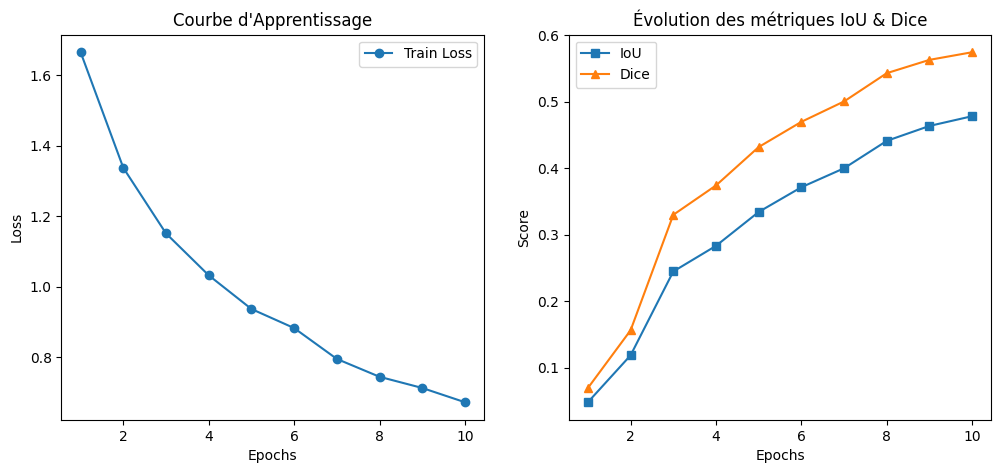

In [12]:
# Tracer la courbe d'apprentissage
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Courbe d'Apprentissage")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), test_iou_scores, label="IoU", marker='s')
plt.plot(range(1, num_epochs + 1), test_dice_scores, label="Dice", marker='^')
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.title("Évolution des métriques IoU & Dice")
plt.legend()

plt.show()

# Sauvegarde des métriques
with open("training_metrics_unet.pkl", "wb") as f:
    pickle.dump({"train_losses": train_losses, "test_iou_scores": test_iou_scores, "test_dice_scores": test_dice_scores}, f)

In [13]:
# Calculer les moyennes
iou_mean = torch.tensor(iou_scores).nanmean(dim=0)
dice_mean = torch.tensor(dice_scores).nanmean(dim=0)

print("IoU moyen par classe :", iou_mean)
print("Dice Coefficient moyen par classe :", dice_mean)

IoU moyen par classe: tensor(0.4781)
Dice Coefficient moyen par classe: tensor(0.5742)


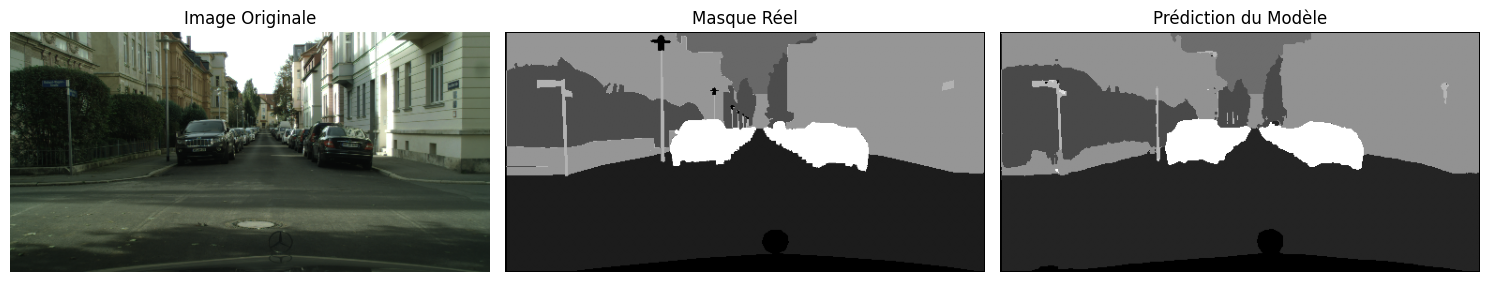

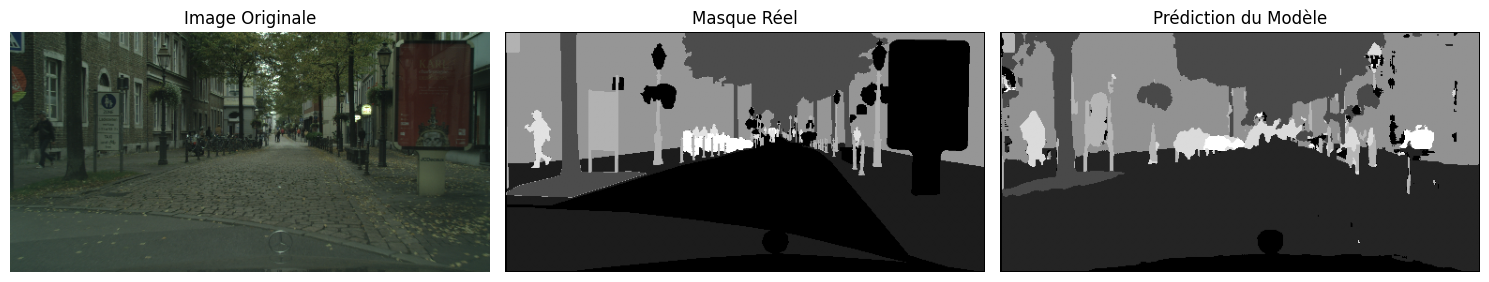

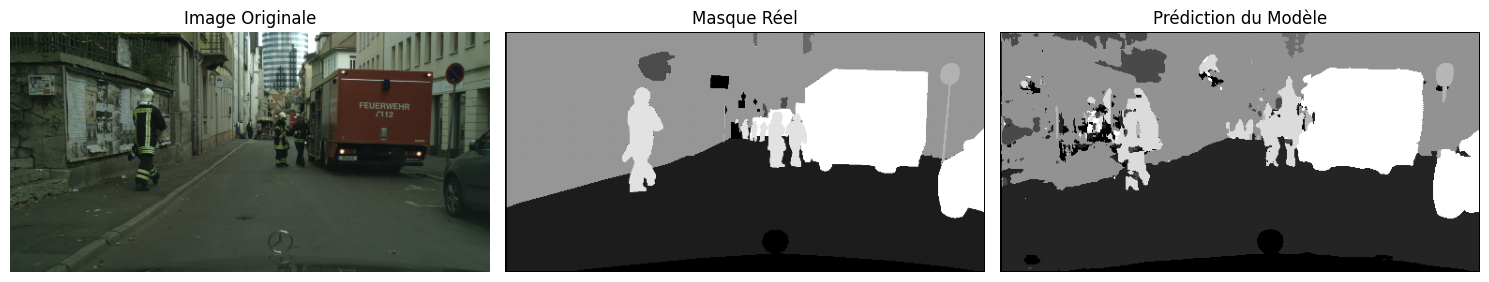

In [81]:
# Fonction pour afficher une prédiction aléatoire
def afficher_prediction_aleatoire(model, image_paths, mask_paths, image_transform, mask_transform, num_classes):
    # Sélectionner un index aléatoire
    idx = random.randint(0, len(image_paths) - 1)

    # Charger l'image et le masque
    image_path = image_paths[idx]
    mask_path = mask_paths[idx]

    # Vérifier si les fichiers existent
    if not os.path.exists(image_path):
        print(f"Fichier image introuvable : {image_path}")
        return
    if not os.path.exists(mask_path):
        print(f"Fichier masque introuvable : {mask_path}")
        return

    # Lire l'image et le masque
    image = cv2.imread(image_path)
    if image is None:
        print(f"Erreur de lecture de l'image : {image_path}")
        return

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Appliquer les transformations
    image_transformed = image_transform(image).unsqueeze(0)  # Ajouter une dimension batch
    mask_transformed = mask_transform(mask)

    # Faire une prédiction avec le modèle
    model.eval()
    with torch.no_grad():
        output = model(image_transformed)
        pred = torch.argmax(output, dim=1).squeeze().cpu().numpy()

    # Afficher l'image, le masque réel et la prédiction
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(image)
    axes[0].set_title("Image Originale")
    axes[0].axis('off')

    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title("Masque Réel")
    axes[1].axis('off')

    axes[2].imshow(pred, cmap='gray')
    axes[2].set_title("Prédiction du Modèle")
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

# Utiliser la fonction pour afficher une prédiction aléatoire
afficher_prediction_aleatoire(model, train_images, train_masks, image_transform, mask_transform, num_classes=8)
afficher_prediction_aleatoire(model, train_images, train_masks, image_transform, mask_transform, num_classes=8)
afficher_prediction_aleatoire(model, train_images, train_masks, image_transform, mask_transform, num_classes=8)

In [14]:
# Fonction pour sauvegarder le modèle
def save_model(model, path="unet_model.pth"):
    torch.save(model.state_dict(), path)
    print(f"Modèle sauvegardé à {path}")

# Sauvegardez le modèle après l'entraînement
save_model(model)

Modèle sauvegardé à unet_model.pth


### 2 - VGG16-UNet


In [59]:
class VGG16UNET(nn.Module):
    def __init__(self, n_channels=3, n_classes=8):
        super(VGG16UNET, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        
        # Encoder
        self.inc = DoubleConv(n_channels, 16)
        self.down1 = Down(16, 32)
        self.down2 = Down(32, 64)
        self.down3 = Down(64, 128)
        
        # Decoder
        self.up1 = Up(128, 64)
        self.up2 = Up(64, 32)
        self.up3 = Up(32, 16)
        
        # Output layer
        self.outc = OutConv(16, n_classes)

    def forward(self, x):
        # Encoder path
        x1 = self.inc(x)       # 16 canaux
        x2 = self.down1(x1)    # 32 canaux
        x3 = self.down2(x2)    # 64 canaux
        x4 = self.down3(x3)    # 128 canaux
        
        # Decoder path with skip connections
        x = self.up1(x4, x3)   # 64 canaux
        x = self.up2(x, x2)    # 32 canaux
        x = self.up3(x, x1)    # 16 canaux
        
        return self.outc(x)    # n_classes canaux

In [60]:
# Instancier le nouveau modèle
model = VGG16UNET(n_channels=3, n_classes=8)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Stockage des métriques
train_losses = []
test_iou_scores = []
test_dice_scores = []

# Boucle d'entraînement
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    
    for images, masks in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{num_epochs}"):
        if masks.dim() == 4 and masks.size(1) == 1:
            masks = masks.squeeze(1)
        masks = masks.long()
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    train_losses.append(epoch_loss / len(train_loader))  # Stockage de la perte
    
    # Évaluation
    model.eval()
    iou_scores = []
    dice_scores = []
    with torch.no_grad():
        for images, masks in test_loader:
            if masks.dim() == 4 and masks.size(1) == 1:
                masks = masks.squeeze(1)
            masks = masks.long()
            
            outputs = model(images)
            iou = calculate_iou(outputs, masks, num_classes=8)
            dice = calculate_dice_coefficient(outputs, masks, num_classes=8)
            
            iou_scores.append(iou)
            dice_scores.append(dice)
        
        mean_iou = sum(iou_scores) / len(iou_scores)
        mean_dice = sum(dice_scores) / len(dice_scores)
        
        test_iou_scores.append(mean_iou)  # Stockage des métriques
        test_dice_scores.append(mean_dice)
        
        print(f"Epoch {epoch + 1}, Test IoU: {mean_iou:.4f}, Test Dice: {mean_dice:.4f}")

Training Epoch 1/10:   0%|          | 0/72 [00:00<?, ?it/s]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 1/10:   1%|▏         | 1/72 [00:02<03:21,  2.84s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 1/10:   3%|▎         | 2/72 [00:05<03:26,  2.94s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 1/10:   4%|▍         | 3/72 [00:08<03:23,  2.95s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 1/10:   6%|▌         | 4/72 [00:11<03:20,  2.95s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 1/10:   7%|▋         | 5/72 [00:14<03:18,  2.97s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 1/10:   8%|▊         | 6/72 [00:17<03:15,  2.96s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 1/10:  10%|▉         | 7/72 [00:20<03:13,  2.97s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 1/10:  11%|█         | 8/72 [00:23<03:11,  2.99s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 1/10:  12%|█▎        | 9/72 [00:26<03:06,  2.96s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 1/10:  14%|█▍        | 10/72 [00:29<03:02,  2.95s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 1/10:  15%|█▌        | 11/72 [00:32<03:00,  2.95s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 1/10:  17%|█▋        | 12/72 [00:35<02:57,  2.96s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 1/10:  18%|█▊        | 13/72 [00:38<02:54,  2.96s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 1/10:  19%|█▉        | 14/72 [00:41<02:52,  2.97s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 1/10:  21%|██        | 15/72 [00:44<02:49,  2.97s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 1/10:  22%|██▏       | 16/72 [00:47<02:45,  2.95s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 1/10:  24%|██▎       | 17/72 [00:50<02:52,  3.14s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 1/10:  25%|██▌       | 18/72 [00:53<02:40,  2.97s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 1/10:  26%|██▋       | 19/72 [00:55<02:29,  2.83s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 1/10:  28%|██▊       | 20/72 [00:58<02:22,  2.75s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 1/10:  29%|██▉       | 21/72 [01:01<02:16,  2.67s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 1/10:  31%|███       | 22/72 [01:03<02:11,  2.62s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 1/10:  32%|███▏      | 23/72 [01:06<02:06,  2.59s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 1/10:  33%|███▎      | 24/72 [01:08<02:02,  2.55s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 1/10:  35%|███▍      | 25/72 [01:11<01:59,  2.54s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 1/10:  36%|███▌      | 26/72 [01:13<01:56,  2.52s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 1/10:  38%|███▊      | 27/72 [01:15<01:53,  2.51s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 1/10:  39%|███▉      | 28/72 [01:18<01:50,  2.50s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 1/10:  40%|████      | 29/72 [01:20<01:47,  2.50s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 1/10:  42%|████▏     | 30/72 [01:23<01:44,  2.48s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 1/10:  43%|████▎     | 31/72 [01:25<01:42,  2.49s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 1/10:  44%|████▍     | 32/72 [01:28<01:39,  2.49s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 1/10:  46%|████▌     | 33/72 [01:30<01:37,  2.50s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 1/10:  47%|████▋     | 34/72 [01:33<01:34,  2.49s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 1/10:  49%|████▊     | 35/72 [01:35<01:32,  2.50s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 1/10:  50%|█████     | 36/72 [01:38<01:30,  2.51s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 1/10:  51%|█████▏    | 37/72 [01:41<01:28,  2.54s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 1/10:  53%|█████▎    | 38/72 [01:43<01:26,  2.54s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 1/10:  54%|█████▍    | 39/72 [01:46<01:23,  2.53s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 1/10:  56%|█████▌    | 40/72 [01:48<01:20,  2.51s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 1/10:  57%|█████▋    | 41/72 [01:51<01:17,  2.51s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 1/10:  58%|█████▊    | 42/72 [01:53<01:14,  2.49s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 1/10:  60%|█████▉    | 43/72 [01:56<01:12,  2.50s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 1/10:  61%|██████    | 44/72 [01:58<01:09,  2.49s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 1/10:  62%|██████▎   | 45/72 [02:00<01:07,  2.49s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 1/10:  64%|██████▍   | 46/72 [02:03<01:04,  2.48s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 1/10:  65%|██████▌   | 47/72 [02:05<01:02,  2.50s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 1/10:  67%|██████▋   | 48/72 [02:08<00:59,  2.49s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 1/10:  68%|██████▊   | 49/72 [02:11<00:57,  2.51s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 1/10:  69%|██████▉   | 50/72 [02:13<00:54,  2.49s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 1/10:  71%|███████   | 51/72 [02:15<00:52,  2.50s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 1/10:  72%|███████▏  | 52/72 [02:18<00:49,  2.48s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 1/10:  74%|███████▎  | 53/72 [02:20<00:46,  2.47s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 1/10:  75%|███████▌  | 54/72 [02:23<00:44,  2.48s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 1/10:  76%|███████▋  | 55/72 [02:25<00:42,  2.51s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 1/10:  78%|███████▊  | 56/72 [02:28<00:40,  2.52s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 1/10:  79%|███████▉  | 57/72 [02:31<00:37,  2.53s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 1/10:  81%|████████  | 58/72 [02:33<00:35,  2.55s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 1/10:  82%|████████▏ | 59/72 [02:36<00:33,  2.57s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 1/10:  83%|████████▎ | 60/72 [02:38<00:30,  2.55s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 1/10:  85%|████████▍ | 61/72 [02:41<00:27,  2.53s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 1/10:  86%|████████▌ | 62/72 [02:43<00:25,  2.52s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 1/10:  88%|████████▊ | 63/72 [02:46<00:22,  2.52s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 1/10:  89%|████████▉ | 64/72 [02:48<00:20,  2.52s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 1/10:  90%|█████████ | 65/72 [02:51<00:17,  2.54s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 1/10:  92%|█████████▏| 66/72 [02:53<00:15,  2.52s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 1/10:  93%|█████████▎| 67/72 [02:56<00:12,  2.52s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 1/10:  94%|█████████▍| 68/72 [02:58<00:10,  2.51s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 1/10:  96%|█████████▌| 69/72 [03:01<00:07,  2.50s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 1/10:  97%|█████████▋| 70/72 [03:03<00:04,  2.50s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 1/10:  99%|█████████▊| 71/72 [03:06<00:02,  2.51s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 1/10: 100%|██████████| 72/72 [03:08<00:00,  2.62s/it]


Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])
Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 s

Training Epoch 2/10:   0%|          | 0/72 [00:00<?, ?it/s]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 2/10:   1%|▏         | 1/72 [00:02<02:55,  2.47s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 2/10:   3%|▎         | 2/72 [00:04<02:54,  2.49s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 2/10:   4%|▍         | 3/72 [00:07<02:51,  2.48s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 2/10:   6%|▌         | 4/72 [00:09<02:49,  2.49s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 2/10:   7%|▋         | 5/72 [00:12<02:48,  2.52s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 2/10:   8%|▊         | 6/72 [00:15<02:45,  2.51s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 2/10:  10%|▉         | 7/72 [00:17<02:42,  2.50s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 2/10:  11%|█         | 8/72 [00:19<02:38,  2.48s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 2/10:  12%|█▎        | 9/72 [00:22<02:36,  2.48s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 2/10:  14%|█▍        | 10/72 [00:24<02:33,  2.48s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 2/10:  15%|█▌        | 11/72 [00:27<02:31,  2.49s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 2/10:  17%|█▋        | 12/72 [00:29<02:30,  2.51s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 2/10:  18%|█▊        | 13/72 [00:32<02:29,  2.54s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 2/10:  19%|█▉        | 14/72 [00:35<02:26,  2.53s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 2/10:  21%|██        | 15/72 [00:37<02:22,  2.51s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 2/10:  22%|██▏       | 16/72 [00:40<02:20,  2.50s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 2/10:  24%|██▎       | 17/72 [00:42<02:18,  2.51s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 2/10:  25%|██▌       | 18/72 [00:45<02:15,  2.50s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 2/10:  26%|██▋       | 19/72 [00:47<02:12,  2.49s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 2/10:  28%|██▊       | 20/72 [00:49<02:08,  2.48s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 2/10:  29%|██▉       | 21/72 [00:52<02:06,  2.48s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 2/10:  31%|███       | 22/72 [00:54<02:04,  2.49s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 2/10:  32%|███▏      | 23/72 [00:57<02:02,  2.49s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 2/10:  33%|███▎      | 24/72 [00:59<02:00,  2.50s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 2/10:  35%|███▍      | 25/72 [01:02<01:57,  2.51s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 2/10:  36%|███▌      | 26/72 [01:04<01:55,  2.51s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 2/10:  38%|███▊      | 27/72 [01:07<01:51,  2.49s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 2/10:  39%|███▉      | 28/72 [01:09<01:49,  2.49s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 2/10:  40%|████      | 29/72 [01:12<01:47,  2.51s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 2/10:  42%|████▏     | 30/72 [01:14<01:45,  2.51s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 2/10:  43%|████▎     | 31/72 [01:17<01:44,  2.54s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 2/10:  44%|████▍     | 32/72 [01:20<01:41,  2.55s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 2/10:  46%|████▌     | 33/72 [01:22<01:38,  2.53s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 2/10:  47%|████▋     | 34/72 [01:25<01:35,  2.52s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 2/10:  49%|████▊     | 35/72 [01:27<01:33,  2.52s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 2/10:  50%|█████     | 36/72 [01:30<01:30,  2.50s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 2/10:  51%|█████▏    | 37/72 [01:32<01:27,  2.51s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 2/10:  53%|█████▎    | 38/72 [01:35<01:25,  2.52s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 2/10:  54%|█████▍    | 39/72 [01:37<01:24,  2.56s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 2/10:  56%|█████▌    | 40/72 [01:40<01:22,  2.59s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 2/10:  57%|█████▋    | 41/72 [01:43<01:20,  2.60s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 2/10:  58%|█████▊    | 42/72 [01:45<01:18,  2.61s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 2/10:  60%|█████▉    | 43/72 [01:48<01:16,  2.64s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 2/10:  61%|██████    | 44/72 [01:51<01:13,  2.61s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 2/10:  62%|██████▎   | 45/72 [01:53<01:10,  2.60s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 2/10:  64%|██████▍   | 46/72 [01:56<01:07,  2.59s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 2/10:  65%|██████▌   | 47/72 [01:58<01:05,  2.63s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 2/10:  67%|██████▋   | 48/72 [02:01<01:02,  2.61s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 2/10:  68%|██████▊   | 49/72 [02:03<00:59,  2.59s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 2/10:  69%|██████▉   | 50/72 [02:06<00:56,  2.58s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 2/10:  71%|███████   | 51/72 [02:08<00:53,  2.54s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 2/10:  72%|███████▏  | 52/72 [02:11<00:50,  2.53s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 2/10:  74%|███████▎  | 53/72 [02:14<00:48,  2.56s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 2/10:  75%|███████▌  | 54/72 [02:16<00:46,  2.56s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 2/10:  76%|███████▋  | 55/72 [02:19<00:43,  2.55s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 2/10:  78%|███████▊  | 56/72 [02:21<00:40,  2.53s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 2/10:  79%|███████▉  | 57/72 [02:24<00:38,  2.54s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 2/10:  81%|████████  | 58/72 [02:26<00:35,  2.54s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 2/10:  82%|████████▏ | 59/72 [02:29<00:33,  2.54s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 2/10:  83%|████████▎ | 60/72 [02:31<00:30,  2.54s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 2/10:  85%|████████▍ | 61/72 [02:34<00:28,  2.56s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 2/10:  86%|████████▌ | 62/72 [02:37<00:25,  2.57s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 2/10:  88%|████████▊ | 63/72 [02:39<00:23,  2.59s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 2/10:  89%|████████▉ | 64/72 [02:42<00:20,  2.59s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 2/10:  90%|█████████ | 65/72 [02:44<00:18,  2.61s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 2/10:  92%|█████████▏| 66/72 [02:47<00:15,  2.60s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 2/10:  93%|█████████▎| 67/72 [02:50<00:12,  2.60s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 2/10:  94%|█████████▍| 68/72 [02:52<00:10,  2.57s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 2/10:  96%|█████████▌| 69/72 [02:55<00:07,  2.58s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 2/10:  97%|█████████▋| 70/72 [02:57<00:05,  2.60s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 2/10:  99%|█████████▊| 71/72 [03:00<00:02,  2.62s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 2/10: 100%|██████████| 72/72 [03:03<00:00,  2.54s/it]


Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])
Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 s

Training Epoch 3/10:   0%|          | 0/72 [00:00<?, ?it/s]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 3/10:   1%|▏         | 1/72 [00:02<02:56,  2.49s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 3/10:   3%|▎         | 2/72 [00:05<03:00,  2.58s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 3/10:   4%|▍         | 3/72 [00:07<03:01,  2.63s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 3/10:   6%|▌         | 4/72 [00:10<02:58,  2.62s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 3/10:   7%|▋         | 5/72 [00:12<02:54,  2.60s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 3/10:   8%|▊         | 6/72 [00:15<02:50,  2.58s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 3/10:  10%|▉         | 7/72 [00:18<02:47,  2.58s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 3/10:  11%|█         | 8/72 [00:20<02:45,  2.58s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 3/10:  12%|█▎        | 9/72 [00:23<02:43,  2.60s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 3/10:  14%|█▍        | 10/72 [00:25<02:41,  2.61s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 3/10:  15%|█▌        | 11/72 [00:28<02:38,  2.61s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 3/10:  17%|█▋        | 12/72 [00:31<02:34,  2.58s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 3/10:  18%|█▊        | 13/72 [00:33<02:30,  2.55s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 3/10:  19%|█▉        | 14/72 [00:36<02:27,  2.54s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 3/10:  21%|██        | 15/72 [00:38<02:25,  2.55s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 3/10:  22%|██▏       | 16/72 [00:41<02:22,  2.55s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 3/10:  24%|██▎       | 17/72 [00:43<02:20,  2.55s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 3/10:  25%|██▌       | 18/72 [00:46<02:16,  2.54s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 3/10:  26%|██▋       | 19/72 [00:48<02:14,  2.54s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 3/10:  28%|██▊       | 20/72 [00:51<02:11,  2.53s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 3/10:  29%|██▉       | 21/72 [00:53<02:09,  2.54s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 3/10:  31%|███       | 22/72 [00:56<02:07,  2.54s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 3/10:  32%|███▏      | 23/72 [00:58<02:04,  2.54s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 3/10:  33%|███▎      | 24/72 [01:01<02:01,  2.53s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 3/10:  35%|███▍      | 25/72 [01:03<01:58,  2.53s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 3/10:  36%|███▌      | 26/72 [01:06<01:56,  2.52s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 3/10:  38%|███▊      | 27/72 [01:09<01:54,  2.54s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 3/10:  39%|███▉      | 28/72 [01:11<01:52,  2.55s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 3/10:  40%|████      | 29/72 [01:14<01:50,  2.56s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 3/10:  42%|████▏     | 30/72 [01:16<01:47,  2.56s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 3/10:  43%|████▎     | 31/72 [01:19<01:45,  2.57s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 3/10:  44%|████▍     | 32/72 [01:22<01:43,  2.58s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 3/10:  46%|████▌     | 33/72 [01:24<01:41,  2.60s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 3/10:  47%|████▋     | 34/72 [01:27<01:38,  2.60s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 3/10:  49%|████▊     | 35/72 [01:29<01:36,  2.60s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 3/10:  50%|█████     | 36/72 [01:32<01:33,  2.60s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 3/10:  51%|█████▏    | 37/72 [01:35<01:31,  2.60s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 3/10:  53%|█████▎    | 38/72 [01:37<01:28,  2.62s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 3/10:  54%|█████▍    | 39/72 [01:40<01:26,  2.62s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 3/10:  56%|█████▌    | 40/72 [01:43<01:24,  2.63s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 3/10:  57%|█████▋    | 41/72 [01:45<01:21,  2.62s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 3/10:  58%|█████▊    | 42/72 [01:48<01:18,  2.60s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 3/10:  60%|█████▉    | 43/72 [01:50<01:14,  2.58s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 3/10:  61%|██████    | 44/72 [01:53<01:12,  2.60s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 3/10:  62%|██████▎   | 45/72 [01:55<01:10,  2.62s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 3/10:  64%|██████▍   | 46/72 [01:58<01:08,  2.63s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 3/10:  65%|██████▌   | 47/72 [02:01<01:06,  2.65s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 3/10:  67%|██████▋   | 48/72 [02:03<01:03,  2.65s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 3/10:  68%|██████▊   | 49/72 [02:06<01:00,  2.63s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 3/10:  69%|██████▉   | 50/72 [02:09<00:57,  2.61s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 3/10:  71%|███████   | 51/72 [02:11<00:55,  2.63s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 3/10:  72%|███████▏  | 52/72 [02:14<00:52,  2.63s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 3/10:  74%|███████▎  | 53/72 [02:16<00:49,  2.60s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 3/10:  75%|███████▌  | 54/72 [02:19<00:46,  2.60s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 3/10:  76%|███████▋  | 55/72 [02:22<00:44,  2.61s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 3/10:  78%|███████▊  | 56/72 [02:24<00:41,  2.62s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 3/10:  79%|███████▉  | 57/72 [02:27<00:39,  2.63s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 3/10:  81%|████████  | 58/72 [02:30<00:36,  2.62s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 3/10:  82%|████████▏ | 59/72 [02:32<00:34,  2.62s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 3/10:  83%|████████▎ | 60/72 [02:35<00:31,  2.61s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 3/10:  85%|████████▍ | 61/72 [02:37<00:28,  2.62s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 3/10:  86%|████████▌ | 62/72 [02:40<00:26,  2.63s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 3/10:  88%|████████▊ | 63/72 [02:43<00:23,  2.61s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 3/10:  89%|████████▉ | 64/72 [02:45<00:20,  2.60s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 3/10:  90%|█████████ | 65/72 [02:48<00:18,  2.61s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 3/10:  92%|█████████▏| 66/72 [02:50<00:15,  2.60s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 3/10:  93%|█████████▎| 67/72 [02:53<00:12,  2.59s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 3/10:  94%|█████████▍| 68/72 [02:56<00:10,  2.59s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 3/10:  96%|█████████▌| 69/72 [02:58<00:07,  2.60s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 3/10:  97%|█████████▋| 70/72 [03:01<00:05,  2.60s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 3/10:  99%|█████████▊| 71/72 [03:03<00:02,  2.58s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 3/10: 100%|██████████| 72/72 [03:06<00:00,  2.59s/it]


Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])
Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 s

Training Epoch 4/10:   0%|          | 0/72 [00:00<?, ?it/s]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 4/10:   1%|▏         | 1/72 [00:02<03:01,  2.55s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 4/10:   3%|▎         | 2/72 [00:05<03:02,  2.61s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 4/10:   4%|▍         | 3/72 [00:07<02:58,  2.58s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 4/10:   6%|▌         | 4/72 [00:10<02:55,  2.58s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 4/10:   7%|▋         | 5/72 [00:12<02:52,  2.58s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 4/10:   8%|▊         | 6/72 [00:15<02:48,  2.56s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 4/10:  10%|▉         | 7/72 [00:18<02:47,  2.58s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 4/10:  11%|█         | 8/72 [00:20<02:45,  2.59s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 4/10:  12%|█▎        | 9/72 [00:23<02:42,  2.57s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 4/10:  14%|█▍        | 10/72 [00:25<02:40,  2.59s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 4/10:  15%|█▌        | 11/72 [00:28<02:36,  2.56s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 4/10:  17%|█▋        | 12/72 [00:30<02:32,  2.55s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 4/10:  18%|█▊        | 13/72 [00:33<02:29,  2.53s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 4/10:  19%|█▉        | 14/72 [00:35<02:27,  2.54s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 4/10:  21%|██        | 15/72 [00:38<02:24,  2.53s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 4/10:  22%|██▏       | 16/72 [00:40<02:22,  2.54s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 4/10:  24%|██▎       | 17/72 [00:43<02:21,  2.57s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 4/10:  25%|██▌       | 18/72 [00:46<02:19,  2.57s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 4/10:  26%|██▋       | 19/72 [00:48<02:17,  2.59s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 4/10:  28%|██▊       | 20/72 [00:51<02:16,  2.62s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 4/10:  29%|██▉       | 21/72 [00:54<02:12,  2.60s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 4/10:  31%|███       | 22/72 [00:56<02:09,  2.59s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 4/10:  32%|███▏      | 23/72 [00:59<02:07,  2.59s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 4/10:  33%|███▎      | 24/72 [01:01<02:03,  2.56s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 4/10:  35%|███▍      | 25/72 [01:04<01:59,  2.54s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 4/10:  36%|███▌      | 26/72 [01:06<01:57,  2.56s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 4/10:  38%|███▊      | 27/72 [01:09<01:56,  2.58s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 4/10:  39%|███▉      | 28/72 [01:12<01:53,  2.58s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 4/10:  40%|████      | 29/72 [01:14<01:50,  2.57s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 4/10:  42%|████▏     | 30/72 [01:17<01:47,  2.57s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 4/10:  43%|████▎     | 31/72 [01:19<01:45,  2.57s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 4/10:  44%|████▍     | 32/72 [01:22<01:43,  2.58s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 4/10:  46%|████▌     | 33/72 [01:24<01:40,  2.58s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 4/10:  47%|████▋     | 34/72 [01:27<01:38,  2.60s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 4/10:  49%|████▊     | 35/72 [01:30<01:36,  2.60s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 4/10:  50%|█████     | 36/72 [01:32<01:33,  2.58s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 4/10:  51%|█████▏    | 37/72 [01:35<01:29,  2.57s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 4/10:  53%|█████▎    | 38/72 [01:37<01:26,  2.54s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 4/10:  54%|█████▍    | 39/72 [01:40<01:24,  2.56s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 4/10:  56%|█████▌    | 40/72 [01:42<01:22,  2.57s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 4/10:  57%|█████▋    | 41/72 [01:45<01:20,  2.59s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 4/10:  58%|█████▊    | 42/72 [01:48<01:17,  2.59s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 4/10:  60%|█████▉    | 43/72 [01:50<01:14,  2.58s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 4/10:  61%|██████    | 44/72 [01:53<01:12,  2.58s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 4/10:  62%|██████▎   | 45/72 [01:55<01:09,  2.59s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 4/10:  64%|██████▍   | 46/72 [01:58<01:07,  2.58s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 4/10:  65%|██████▌   | 47/72 [02:00<01:03,  2.55s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 4/10:  67%|██████▋   | 48/72 [02:03<01:01,  2.56s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 4/10:  68%|██████▊   | 49/72 [02:06<00:59,  2.57s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 4/10:  69%|██████▉   | 50/72 [02:08<00:56,  2.57s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 4/10:  71%|███████   | 51/72 [02:11<00:54,  2.59s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 4/10:  72%|███████▏  | 52/72 [02:13<00:52,  2.60s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 4/10:  74%|███████▎  | 53/72 [02:16<00:49,  2.60s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 4/10:  75%|███████▌  | 54/72 [02:19<00:46,  2.56s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 4/10:  76%|███████▋  | 55/72 [02:21<00:43,  2.57s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 4/10:  78%|███████▊  | 56/72 [02:24<00:40,  2.56s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 4/10:  79%|███████▉  | 57/72 [02:26<00:38,  2.55s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 4/10:  81%|████████  | 58/72 [02:29<00:35,  2.56s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 4/10:  82%|████████▏ | 59/72 [02:31<00:33,  2.57s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 4/10:  83%|████████▎ | 60/72 [02:34<00:30,  2.57s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 4/10:  85%|████████▍ | 61/72 [02:36<00:28,  2.57s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 4/10:  86%|████████▌ | 62/72 [02:39<00:25,  2.56s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 4/10:  88%|████████▊ | 63/72 [02:42<00:23,  2.59s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 4/10:  89%|████████▉ | 64/72 [02:44<00:20,  2.60s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 4/10:  90%|█████████ | 65/72 [02:47<00:18,  2.62s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 4/10:  92%|█████████▏| 66/72 [02:49<00:15,  2.59s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 4/10:  93%|█████████▎| 67/72 [02:52<00:12,  2.59s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 4/10:  94%|█████████▍| 68/72 [02:55<00:10,  2.57s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 4/10:  96%|█████████▌| 69/72 [02:57<00:07,  2.58s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 4/10:  97%|█████████▋| 70/72 [03:00<00:05,  2.57s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 4/10:  99%|█████████▊| 71/72 [03:02<00:02,  2.58s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 4/10: 100%|██████████| 72/72 [03:05<00:00,  2.57s/it]


Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])
Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 s

Training Epoch 5/10:   0%|          | 0/72 [00:00<?, ?it/s]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 5/10:   1%|▏         | 1/72 [00:02<02:58,  2.51s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 5/10:   3%|▎         | 2/72 [00:05<03:02,  2.61s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 5/10:   4%|▍         | 3/72 [00:07<02:58,  2.58s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 5/10:   6%|▌         | 4/72 [00:10<02:53,  2.55s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 5/10:   7%|▋         | 5/72 [00:12<02:51,  2.56s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 5/10:   8%|▊         | 6/72 [00:15<02:50,  2.59s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 5/10:  10%|▉         | 7/72 [00:18<02:47,  2.58s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 5/10:  11%|█         | 8/72 [00:20<02:45,  2.59s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 5/10:  12%|█▎        | 9/72 [00:23<02:43,  2.60s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 5/10:  14%|█▍        | 10/72 [00:25<02:41,  2.60s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 5/10:  15%|█▌        | 11/72 [00:28<02:36,  2.57s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 5/10:  17%|█▋        | 12/72 [00:30<02:34,  2.58s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 5/10:  18%|█▊        | 13/72 [00:33<02:32,  2.59s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 5/10:  19%|█▉        | 14/72 [00:36<02:31,  2.61s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 5/10:  21%|██        | 15/72 [00:38<02:27,  2.59s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 5/10:  22%|██▏       | 16/72 [00:41<02:24,  2.59s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 5/10:  24%|██▎       | 17/72 [00:43<02:21,  2.58s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 5/10:  25%|██▌       | 18/72 [00:46<02:19,  2.59s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 5/10:  26%|██▋       | 19/72 [00:49<02:16,  2.58s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 5/10:  28%|██▊       | 20/72 [00:51<02:15,  2.61s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 5/10:  29%|██▉       | 21/72 [00:54<02:12,  2.60s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 5/10:  31%|███       | 22/72 [00:56<02:09,  2.60s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 5/10:  32%|███▏      | 23/72 [00:59<02:06,  2.59s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 5/10:  33%|███▎      | 24/72 [01:02<02:03,  2.57s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 5/10:  35%|███▍      | 25/72 [01:04<02:00,  2.56s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 5/10:  36%|███▌      | 26/72 [01:07<01:58,  2.57s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 5/10:  38%|███▊      | 27/72 [01:09<01:56,  2.58s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 5/10:  39%|███▉      | 28/72 [01:12<01:53,  2.58s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 5/10:  40%|████      | 29/72 [01:15<01:51,  2.60s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 5/10:  42%|████▏     | 30/72 [01:17<01:48,  2.57s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 5/10:  43%|████▎     | 31/72 [01:20<01:46,  2.59s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 5/10:  44%|████▍     | 32/72 [01:22<01:44,  2.62s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 5/10:  46%|████▌     | 33/72 [01:25<01:42,  2.63s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 5/10:  47%|████▋     | 34/72 [01:28<01:38,  2.60s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 5/10:  49%|████▊     | 35/72 [01:30<01:35,  2.59s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 5/10:  50%|█████     | 36/72 [01:33<01:32,  2.57s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 5/10:  51%|█████▏    | 37/72 [01:35<01:30,  2.58s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 5/10:  53%|█████▎    | 38/72 [01:38<01:27,  2.58s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 5/10:  54%|█████▍    | 39/72 [01:40<01:25,  2.58s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 5/10:  56%|█████▌    | 40/72 [01:43<01:23,  2.60s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 5/10:  57%|█████▋    | 41/72 [01:46<01:20,  2.59s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 5/10:  58%|█████▊    | 42/72 [01:48<01:17,  2.59s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 5/10:  60%|█████▉    | 43/72 [01:51<01:14,  2.58s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 5/10:  61%|██████    | 44/72 [01:53<01:12,  2.61s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 5/10:  62%|██████▎   | 45/72 [01:56<01:10,  2.60s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 5/10:  64%|██████▍   | 46/72 [01:59<01:07,  2.60s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 5/10:  65%|██████▌   | 47/72 [02:01<01:05,  2.61s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 5/10:  67%|██████▋   | 48/72 [02:04<01:02,  2.60s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 5/10:  68%|██████▊   | 49/72 [02:06<00:59,  2.58s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 5/10:  69%|██████▉   | 50/72 [02:09<00:57,  2.59s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 5/10:  71%|███████   | 51/72 [02:12<00:54,  2.61s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 5/10:  72%|███████▏  | 52/72 [02:14<00:51,  2.60s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 5/10:  74%|███████▎  | 53/72 [02:17<00:49,  2.61s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 5/10:  75%|███████▌  | 54/72 [02:19<00:47,  2.63s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 5/10:  76%|███████▋  | 55/72 [02:22<00:44,  2.64s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 5/10:  78%|███████▊  | 56/72 [02:25<00:42,  2.64s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 5/10:  79%|███████▉  | 57/72 [02:27<00:39,  2.64s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 5/10:  81%|████████  | 58/72 [02:30<00:36,  2.63s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 5/10:  82%|████████▏ | 59/72 [02:33<00:34,  2.62s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 5/10:  83%|████████▎ | 60/72 [02:35<00:31,  2.60s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 5/10:  85%|████████▍ | 61/72 [02:38<00:28,  2.57s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 5/10:  86%|████████▌ | 62/72 [02:40<00:25,  2.59s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 5/10:  88%|████████▊ | 63/72 [02:43<00:23,  2.59s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 5/10:  89%|████████▉ | 64/72 [02:45<00:20,  2.59s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 5/10:  90%|█████████ | 65/72 [02:48<00:18,  2.60s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 5/10:  92%|█████████▏| 66/72 [02:51<00:15,  2.59s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 5/10:  93%|█████████▎| 67/72 [02:53<00:13,  2.60s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 5/10:  94%|█████████▍| 68/72 [02:56<00:10,  2.62s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 5/10:  96%|█████████▌| 69/72 [02:59<00:07,  2.62s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 5/10:  97%|█████████▋| 70/72 [03:01<00:05,  2.61s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 5/10:  99%|█████████▊| 71/72 [03:04<00:02,  2.61s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 5/10: 100%|██████████| 72/72 [03:06<00:00,  2.60s/it]


Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])
Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 s

Training Epoch 6/10:   0%|          | 0/72 [00:00<?, ?it/s]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 6/10:   1%|▏         | 1/72 [00:02<03:00,  2.54s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 6/10:   3%|▎         | 2/72 [00:05<03:01,  2.59s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 6/10:   4%|▍         | 3/72 [00:07<02:56,  2.56s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 6/10:   6%|▌         | 4/72 [00:10<02:51,  2.53s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 6/10:   7%|▋         | 5/72 [00:12<02:51,  2.55s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 6/10:   8%|▊         | 6/72 [00:15<02:49,  2.57s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 6/10:  10%|▉         | 7/72 [00:17<02:47,  2.58s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 6/10:  11%|█         | 8/72 [00:20<02:45,  2.59s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 6/10:  12%|█▎        | 9/72 [00:23<02:44,  2.61s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 6/10:  14%|█▍        | 10/72 [00:25<02:43,  2.64s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 6/10:  15%|█▌        | 11/72 [00:28<02:42,  2.67s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 6/10:  17%|█▋        | 12/72 [00:31<02:40,  2.68s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 6/10:  18%|█▊        | 13/72 [00:34<02:37,  2.67s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 6/10:  19%|█▉        | 14/72 [00:36<02:35,  2.67s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 6/10:  21%|██        | 15/72 [00:39<02:32,  2.67s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 6/10:  22%|██▏       | 16/72 [00:41<02:28,  2.65s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 6/10:  24%|██▎       | 17/72 [00:44<02:26,  2.66s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 6/10:  25%|██▌       | 18/72 [00:47<02:22,  2.65s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 6/10:  26%|██▋       | 19/72 [00:49<02:19,  2.63s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 6/10:  28%|██▊       | 20/72 [00:52<02:16,  2.63s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 6/10:  29%|██▉       | 21/72 [00:55<02:14,  2.64s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 6/10:  31%|███       | 22/72 [00:57<02:12,  2.65s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 6/10:  32%|███▏      | 23/72 [01:00<02:09,  2.65s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 6/10:  33%|███▎      | 24/72 [01:03<02:07,  2.65s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 6/10:  35%|███▍      | 25/72 [01:05<02:04,  2.65s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 6/10:  36%|███▌      | 26/72 [01:08<02:02,  2.67s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 6/10:  38%|███▊      | 27/72 [01:11<01:58,  2.63s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 6/10:  39%|███▉      | 28/72 [01:13<01:54,  2.60s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 6/10:  40%|████      | 29/72 [01:16<01:51,  2.59s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 6/10:  42%|████▏     | 30/72 [01:18<01:48,  2.57s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 6/10:  43%|████▎     | 31/72 [01:21<01:46,  2.59s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 6/10:  44%|████▍     | 32/72 [01:23<01:43,  2.59s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 6/10:  46%|████▌     | 33/72 [01:26<01:41,  2.62s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 6/10:  47%|████▋     | 34/72 [01:29<01:39,  2.62s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 6/10:  49%|████▊     | 35/72 [01:31<01:37,  2.63s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 6/10:  50%|█████     | 36/72 [01:34<01:34,  2.62s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 6/10:  51%|█████▏    | 37/72 [01:37<01:30,  2.60s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 6/10:  53%|█████▎    | 38/72 [01:39<01:27,  2.58s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 6/10:  54%|█████▍    | 39/72 [01:42<01:25,  2.59s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 6/10:  56%|█████▌    | 40/72 [01:44<01:23,  2.60s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 6/10:  57%|█████▋    | 41/72 [01:47<01:21,  2.61s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 6/10:  58%|█████▊    | 42/72 [01:50<01:18,  2.62s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 6/10:  60%|█████▉    | 43/72 [01:52<01:16,  2.63s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 6/10:  61%|██████    | 44/72 [01:55<01:13,  2.63s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 6/10:  62%|██████▎   | 45/72 [01:57<01:10,  2.63s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 6/10:  64%|██████▍   | 46/72 [02:00<01:08,  2.62s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 6/10:  65%|██████▌   | 47/72 [02:03<01:06,  2.64s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 6/10:  67%|██████▋   | 48/72 [02:05<01:04,  2.67s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 6/10:  68%|██████▊   | 49/72 [02:08<01:01,  2.66s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 6/10:  69%|██████▉   | 50/72 [02:11<00:58,  2.64s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 6/10:  71%|███████   | 51/72 [02:13<00:55,  2.65s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 6/10:  72%|███████▏  | 52/72 [02:16<00:53,  2.66s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 6/10:  74%|███████▎  | 53/72 [02:19<00:50,  2.66s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 6/10:  75%|███████▌  | 54/72 [02:21<00:48,  2.68s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 6/10:  76%|███████▋  | 55/72 [02:24<00:45,  2.67s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 6/10:  78%|███████▊  | 56/72 [02:27<00:42,  2.66s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 6/10:  79%|███████▉  | 57/72 [02:29<00:39,  2.66s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 6/10:  81%|████████  | 58/72 [02:32<00:37,  2.66s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 6/10:  82%|████████▏ | 59/72 [02:35<00:34,  2.67s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 6/10:  83%|████████▎ | 60/72 [02:37<00:31,  2.65s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 6/10:  85%|████████▍ | 61/72 [02:40<00:29,  2.65s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 6/10:  86%|████████▌ | 62/72 [02:43<00:26,  2.66s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 6/10:  88%|████████▊ | 63/72 [02:45<00:23,  2.66s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 6/10:  89%|████████▉ | 64/72 [02:48<00:21,  2.65s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 6/10:  90%|█████████ | 65/72 [02:51<00:18,  2.65s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 6/10:  92%|█████████▏| 66/72 [02:53<00:15,  2.66s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 6/10:  93%|█████████▎| 67/72 [02:56<00:13,  2.67s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 6/10:  94%|█████████▍| 68/72 [02:59<00:10,  2.67s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 6/10:  96%|█████████▌| 69/72 [03:01<00:07,  2.66s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 6/10:  97%|█████████▋| 70/72 [03:04<00:05,  2.64s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 6/10:  99%|█████████▊| 71/72 [03:07<00:02,  2.63s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 6/10: 100%|██████████| 72/72 [03:09<00:00,  2.63s/it]


Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])
Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 s

Training Epoch 7/10:   0%|          | 0/72 [00:00<?, ?it/s]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 7/10:   1%|▏         | 1/72 [00:02<03:00,  2.54s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 7/10:   3%|▎         | 2/72 [00:05<03:02,  2.60s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 7/10:   4%|▍         | 3/72 [00:07<02:58,  2.59s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 7/10:   6%|▌         | 4/72 [00:10<02:56,  2.59s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 7/10:   7%|▋         | 5/72 [00:12<02:53,  2.59s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 7/10:   8%|▊         | 6/72 [00:15<02:51,  2.60s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 7/10:  10%|▉         | 7/72 [00:18<02:47,  2.58s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 7/10:  11%|█         | 8/72 [00:20<02:43,  2.56s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 7/10:  12%|█▎        | 9/72 [00:23<02:41,  2.57s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 7/10:  14%|█▍        | 10/72 [00:25<02:39,  2.57s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 7/10:  15%|█▌        | 11/72 [00:28<02:39,  2.61s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 7/10:  17%|█▋        | 12/72 [00:31<02:36,  2.61s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 7/10:  18%|█▊        | 13/72 [00:33<02:31,  2.57s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 7/10:  19%|█▉        | 14/72 [00:36<02:29,  2.57s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 7/10:  21%|██        | 15/72 [00:38<02:27,  2.58s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 7/10:  22%|██▏       | 16/72 [00:41<02:24,  2.58s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 7/10:  24%|██▎       | 17/72 [00:43<02:21,  2.58s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 7/10:  25%|██▌       | 18/72 [00:46<02:18,  2.56s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 7/10:  26%|██▋       | 19/72 [00:48<02:15,  2.55s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 7/10:  28%|██▊       | 20/72 [00:51<02:11,  2.54s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 7/10:  29%|██▉       | 21/72 [00:54<02:09,  2.54s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 7/10:  31%|███       | 22/72 [00:56<02:07,  2.56s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 7/10:  32%|███▏      | 23/72 [00:59<02:06,  2.59s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 7/10:  33%|███▎      | 24/72 [01:01<02:04,  2.60s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 7/10:  35%|███▍      | 25/72 [01:04<02:01,  2.58s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 7/10:  36%|███▌      | 26/72 [01:06<01:57,  2.56s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 7/10:  38%|███▊      | 27/72 [01:09<01:54,  2.54s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 7/10:  39%|███▉      | 28/72 [01:12<01:53,  2.57s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 7/10:  40%|████      | 29/72 [01:14<01:51,  2.58s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 7/10:  42%|████▏     | 30/72 [01:17<01:48,  2.59s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 7/10:  43%|████▎     | 31/72 [01:19<01:45,  2.57s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 7/10:  44%|████▍     | 32/72 [01:22<01:41,  2.54s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 7/10:  46%|████▌     | 33/72 [01:24<01:39,  2.56s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 7/10:  47%|████▋     | 34/72 [01:27<01:37,  2.56s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 7/10:  49%|████▊     | 35/72 [01:30<01:36,  2.60s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 7/10:  50%|█████     | 36/72 [01:32<01:33,  2.61s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 7/10:  51%|█████▏    | 37/72 [01:35<01:31,  2.62s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 7/10:  53%|█████▎    | 38/72 [01:37<01:28,  2.60s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 7/10:  54%|█████▍    | 39/72 [01:40<01:25,  2.58s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 7/10:  56%|█████▌    | 40/72 [01:43<01:22,  2.58s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 7/10:  57%|█████▋    | 41/72 [01:45<01:19,  2.58s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 7/10:  58%|█████▊    | 42/72 [01:48<01:16,  2.56s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 7/10:  60%|█████▉    | 43/72 [01:50<01:15,  2.59s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 7/10:  61%|██████    | 44/72 [01:53<01:13,  2.62s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 7/10:  62%|██████▎   | 45/72 [01:56<01:10,  2.60s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 7/10:  64%|██████▍   | 46/72 [01:58<01:07,  2.58s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 7/10:  65%|██████▌   | 47/72 [02:01<01:04,  2.58s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 7/10:  67%|██████▋   | 48/72 [02:03<01:02,  2.59s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 7/10:  68%|██████▊   | 49/72 [02:06<00:59,  2.61s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 7/10:  69%|██████▉   | 50/72 [02:09<00:57,  2.61s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 7/10:  71%|███████   | 51/72 [02:11<00:54,  2.61s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 7/10:  72%|███████▏  | 52/72 [02:14<00:52,  2.62s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 7/10:  74%|███████▎  | 53/72 [02:16<00:49,  2.63s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 7/10:  75%|███████▌  | 54/72 [02:19<00:49,  2.74s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 7/10:  76%|███████▋  | 55/72 [02:22<00:46,  2.74s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 7/10:  78%|███████▊  | 56/72 [02:25<00:42,  2.67s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 7/10:  79%|███████▉  | 57/72 [02:27<00:39,  2.64s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 7/10:  81%|████████  | 58/72 [02:30<00:36,  2.61s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 7/10:  82%|████████▏ | 59/72 [02:32<00:33,  2.58s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 7/10:  83%|████████▎ | 60/72 [02:35<00:30,  2.57s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 7/10:  85%|████████▍ | 61/72 [02:38<00:28,  2.60s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 7/10:  86%|████████▌ | 62/72 [02:40<00:25,  2.60s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 7/10:  88%|████████▊ | 63/72 [02:43<00:23,  2.60s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 7/10:  89%|████████▉ | 64/72 [02:45<00:20,  2.56s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 7/10:  90%|█████████ | 65/72 [02:48<00:17,  2.55s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 7/10:  92%|█████████▏| 66/72 [02:50<00:15,  2.54s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 7/10:  93%|█████████▎| 67/72 [02:53<00:12,  2.54s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 7/10:  94%|█████████▍| 68/72 [02:55<00:10,  2.54s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 7/10:  96%|█████████▌| 69/72 [02:58<00:07,  2.57s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 7/10:  97%|█████████▋| 70/72 [03:01<00:05,  2.56s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 7/10:  99%|█████████▊| 71/72 [03:03<00:02,  2.53s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 7/10: 100%|██████████| 72/72 [03:06<00:00,  2.58s/it]


Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])
Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 s

Training Epoch 8/10:   0%|          | 0/72 [00:00<?, ?it/s]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 8/10:   1%|▏         | 1/72 [00:02<03:03,  2.58s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 8/10:   3%|▎         | 2/72 [00:05<03:02,  2.61s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 8/10:   4%|▍         | 3/72 [00:07<03:02,  2.64s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 8/10:   6%|▌         | 4/72 [00:10<02:58,  2.62s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 8/10:   7%|▋         | 5/72 [00:13<02:56,  2.63s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 8/10:   8%|▊         | 6/72 [00:15<02:51,  2.59s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 8/10:  10%|▉         | 7/72 [00:18<02:48,  2.58s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 8/10:  11%|█         | 8/72 [00:20<02:46,  2.60s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 8/10:  12%|█▎        | 9/72 [00:23<02:43,  2.59s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 8/10:  14%|█▍        | 10/72 [00:25<02:39,  2.58s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 8/10:  15%|█▌        | 11/72 [00:28<02:39,  2.62s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 8/10:  17%|█▋        | 12/72 [00:31<02:37,  2.62s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 8/10:  18%|█▊        | 13/72 [00:33<02:33,  2.60s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 8/10:  19%|█▉        | 14/72 [00:36<02:29,  2.58s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 8/10:  21%|██        | 15/72 [00:39<02:27,  2.59s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 8/10:  22%|██▏       | 16/72 [00:41<02:25,  2.60s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 8/10:  24%|██▎       | 17/72 [00:44<02:24,  2.63s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 8/10:  25%|██▌       | 18/72 [00:46<02:22,  2.63s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 8/10:  26%|██▋       | 19/72 [00:49<02:19,  2.63s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 8/10:  28%|██▊       | 20/72 [00:52<02:16,  2.62s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 8/10:  29%|██▉       | 21/72 [00:54<02:13,  2.61s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 8/10:  31%|███       | 22/72 [00:57<02:10,  2.60s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 8/10:  32%|███▏      | 23/72 [01:00<02:08,  2.61s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 8/10:  33%|███▎      | 24/72 [01:02<02:04,  2.60s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 8/10:  35%|███▍      | 25/72 [01:05<02:03,  2.62s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 8/10:  36%|███▌      | 26/72 [01:07<02:01,  2.64s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 8/10:  38%|███▊      | 27/72 [01:10<01:58,  2.63s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 8/10:  39%|███▉      | 28/72 [01:13<01:54,  2.61s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 8/10:  40%|████      | 29/72 [01:15<01:52,  2.62s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 8/10:  42%|████▏     | 30/72 [01:18<01:49,  2.62s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 8/10:  43%|████▎     | 31/72 [01:21<01:47,  2.63s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 8/10:  44%|████▍     | 32/72 [01:23<01:44,  2.62s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 8/10:  46%|████▌     | 33/72 [01:26<01:42,  2.62s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 8/10:  47%|████▋     | 34/72 [01:28<01:39,  2.61s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 8/10:  49%|████▊     | 35/72 [01:31<01:35,  2.58s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 8/10:  50%|█████     | 36/72 [01:33<01:32,  2.56s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 8/10:  51%|█████▏    | 37/72 [01:36<01:29,  2.55s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 8/10:  53%|█████▎    | 38/72 [01:38<01:26,  2.54s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 8/10:  54%|█████▍    | 39/72 [01:41<01:23,  2.54s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 8/10:  56%|█████▌    | 40/72 [01:43<01:21,  2.54s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 8/10:  57%|█████▋    | 41/72 [01:46<01:18,  2.55s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 8/10:  58%|█████▊    | 42/72 [01:49<01:15,  2.53s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 8/10:  60%|█████▉    | 43/72 [01:51<01:13,  2.53s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 8/10:  61%|██████    | 44/72 [01:54<01:10,  2.52s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 8/10:  62%|██████▎   | 45/72 [01:56<01:07,  2.50s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 8/10:  64%|██████▍   | 46/72 [01:59<01:05,  2.52s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 8/10:  65%|██████▌   | 47/72 [02:01<01:03,  2.53s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 8/10:  67%|██████▋   | 48/72 [02:04<01:01,  2.56s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 8/10:  68%|██████▊   | 49/72 [02:06<00:59,  2.57s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 8/10:  69%|██████▉   | 50/72 [02:09<00:56,  2.57s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 8/10:  71%|███████   | 51/72 [02:11<00:54,  2.57s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 8/10:  72%|███████▏  | 52/72 [02:14<00:51,  2.59s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 8/10:  74%|███████▎  | 53/72 [02:17<00:49,  2.62s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 8/10:  75%|███████▌  | 54/72 [02:19<00:47,  2.62s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 8/10:  76%|███████▋  | 55/72 [02:22<00:44,  2.61s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 8/10:  78%|███████▊  | 56/72 [02:25<00:41,  2.60s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 8/10:  79%|███████▉  | 57/72 [02:27<00:39,  2.61s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 8/10:  81%|████████  | 58/72 [02:30<00:36,  2.59s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 8/10:  82%|████████▏ | 59/72 [02:32<00:33,  2.60s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 8/10:  83%|████████▎ | 60/72 [02:35<00:31,  2.62s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 8/10:  85%|████████▍ | 61/72 [02:38<00:28,  2.62s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 8/10:  86%|████████▌ | 62/72 [02:40<00:26,  2.63s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 8/10:  88%|████████▊ | 63/72 [02:43<00:23,  2.62s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 8/10:  89%|████████▉ | 64/72 [02:46<00:20,  2.61s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 8/10:  90%|█████████ | 65/72 [02:48<00:18,  2.60s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 8/10:  92%|█████████▏| 66/72 [02:51<00:15,  2.58s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 8/10:  93%|█████████▎| 67/72 [02:53<00:12,  2.56s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 8/10:  94%|█████████▍| 68/72 [02:56<00:10,  2.54s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 8/10:  96%|█████████▌| 69/72 [02:58<00:07,  2.54s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 8/10:  97%|█████████▋| 70/72 [03:01<00:05,  2.54s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 8/10:  99%|█████████▊| 71/72 [03:03<00:02,  2.54s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 8/10: 100%|██████████| 72/72 [03:06<00:00,  2.59s/it]


Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])
Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 s

Training Epoch 9/10:   0%|          | 0/72 [00:00<?, ?it/s]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 9/10:   1%|▏         | 1/72 [00:02<03:01,  2.55s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 9/10:   3%|▎         | 2/72 [00:05<03:05,  2.65s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 9/10:   4%|▍         | 3/72 [00:07<03:03,  2.66s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 9/10:   6%|▌         | 4/72 [00:10<03:00,  2.65s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 9/10:   7%|▋         | 5/72 [00:13<02:57,  2.65s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 9/10:   8%|▊         | 6/72 [00:15<02:54,  2.64s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 9/10:  10%|▉         | 7/72 [00:18<02:51,  2.64s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 9/10:  11%|█         | 8/72 [00:21<02:46,  2.60s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 9/10:  12%|█▎        | 9/72 [00:23<02:45,  2.63s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 9/10:  14%|█▍        | 10/72 [00:26<02:41,  2.61s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 9/10:  15%|█▌        | 11/72 [00:28<02:40,  2.63s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 9/10:  17%|█▋        | 12/72 [00:31<02:39,  2.66s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 9/10:  18%|█▊        | 13/72 [00:34<02:36,  2.66s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 9/10:  19%|█▉        | 14/72 [00:37<02:35,  2.67s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 9/10:  21%|██        | 15/72 [00:39<02:32,  2.67s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 9/10:  22%|██▏       | 16/72 [00:42<02:28,  2.65s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 9/10:  24%|██▎       | 17/72 [00:44<02:25,  2.65s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 9/10:  25%|██▌       | 18/72 [00:47<02:23,  2.66s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 9/10:  26%|██▋       | 19/72 [00:50<02:21,  2.66s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 9/10:  28%|██▊       | 20/72 [00:52<02:18,  2.65s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 9/10:  29%|██▉       | 21/72 [00:55<02:15,  2.66s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 9/10:  31%|███       | 22/72 [00:58<02:13,  2.66s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 9/10:  32%|███▏      | 23/72 [01:00<02:11,  2.67s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 9/10:  33%|███▎      | 24/72 [01:03<02:08,  2.68s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 9/10:  35%|███▍      | 25/72 [01:06<02:05,  2.68s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 9/10:  36%|███▌      | 26/72 [01:08<02:02,  2.66s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 9/10:  38%|███▊      | 27/72 [01:11<01:59,  2.65s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 9/10:  39%|███▉      | 28/72 [01:14<01:56,  2.66s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 9/10:  40%|████      | 29/72 [01:16<01:54,  2.65s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 9/10:  42%|████▏     | 30/72 [01:19<01:51,  2.66s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 9/10:  43%|████▎     | 31/72 [01:22<01:48,  2.65s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 9/10:  44%|████▍     | 32/72 [01:24<01:45,  2.63s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 9/10:  46%|████▌     | 33/72 [01:27<01:43,  2.64s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 9/10:  47%|████▋     | 34/72 [01:30<01:41,  2.66s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 9/10:  49%|████▊     | 35/72 [01:32<01:39,  2.68s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 9/10:  50%|█████     | 36/72 [01:35<01:36,  2.67s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 9/10:  51%|█████▏    | 37/72 [01:38<01:33,  2.67s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 9/10:  53%|█████▎    | 38/72 [01:40<01:30,  2.66s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 9/10:  54%|█████▍    | 39/72 [01:43<01:27,  2.66s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 9/10:  56%|█████▌    | 40/72 [01:46<01:24,  2.65s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 9/10:  57%|█████▋    | 41/72 [01:48<01:22,  2.66s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 9/10:  58%|█████▊    | 42/72 [01:51<01:19,  2.66s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 9/10:  60%|█████▉    | 43/72 [01:54<01:16,  2.64s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 9/10:  61%|██████    | 44/72 [01:56<01:13,  2.62s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 9/10:  62%|██████▎   | 45/72 [01:59<01:10,  2.62s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 9/10:  64%|██████▍   | 46/72 [02:01<01:07,  2.61s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 9/10:  65%|██████▌   | 47/72 [02:04<01:05,  2.62s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 9/10:  67%|██████▋   | 48/72 [02:07<01:03,  2.63s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 9/10:  68%|██████▊   | 49/72 [02:09<01:00,  2.65s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 9/10:  69%|██████▉   | 50/72 [02:12<00:58,  2.66s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 9/10:  71%|███████   | 51/72 [02:15<00:55,  2.66s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 9/10:  72%|███████▏  | 52/72 [02:17<00:53,  2.65s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 9/10:  74%|███████▎  | 53/72 [02:20<00:50,  2.66s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 9/10:  75%|███████▌  | 54/72 [02:23<00:48,  2.67s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 9/10:  76%|███████▋  | 55/72 [02:25<00:45,  2.66s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 9/10:  78%|███████▊  | 56/72 [02:28<00:42,  2.66s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 9/10:  79%|███████▉  | 57/72 [02:31<00:40,  2.67s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 9/10:  81%|████████  | 58/72 [02:33<00:37,  2.66s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 9/10:  82%|████████▏ | 59/72 [02:36<00:34,  2.67s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 9/10:  83%|████████▎ | 60/72 [02:39<00:32,  2.67s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 9/10:  85%|████████▍ | 61/72 [02:41<00:29,  2.69s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 9/10:  86%|████████▌ | 62/72 [02:44<00:26,  2.68s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 9/10:  88%|████████▊ | 63/72 [02:47<00:24,  2.68s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 9/10:  89%|████████▉ | 64/72 [02:49<00:21,  2.65s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 9/10:  90%|█████████ | 65/72 [02:52<00:18,  2.65s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 9/10:  92%|█████████▏| 66/72 [02:55<00:15,  2.63s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 9/10:  93%|█████████▎| 67/72 [02:57<00:13,  2.65s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 9/10:  94%|█████████▍| 68/72 [03:00<00:10,  2.64s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 9/10:  96%|█████████▌| 69/72 [03:03<00:07,  2.64s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 9/10:  97%|█████████▋| 70/72 [03:05<00:05,  2.64s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 9/10:  99%|█████████▊| 71/72 [03:08<00:02,  2.63s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 9/10: 100%|██████████| 72/72 [03:10<00:00,  2.65s/it]


Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])
Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 s

Training Epoch 10/10:   0%|          | 0/72 [00:00<?, ?it/s]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 10/10:   1%|▏         | 1/72 [00:02<03:01,  2.56s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 10/10:   3%|▎         | 2/72 [00:05<03:07,  2.68s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 10/10:   4%|▍         | 3/72 [00:07<03:04,  2.68s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 10/10:   6%|▌         | 4/72 [00:10<03:01,  2.67s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 10/10:   7%|▋         | 5/72 [00:13<02:59,  2.67s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 10/10:   8%|▊         | 6/72 [00:15<02:54,  2.65s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 10/10:  10%|▉         | 7/72 [00:18<02:52,  2.65s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 10/10:  11%|█         | 8/72 [00:21<02:50,  2.66s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 10/10:  12%|█▎        | 9/72 [00:23<02:47,  2.66s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 10/10:  14%|█▍        | 10/72 [00:26<02:45,  2.67s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 10/10:  15%|█▌        | 11/72 [00:29<02:42,  2.67s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 10/10:  17%|█▋        | 12/72 [00:31<02:39,  2.66s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 10/10:  18%|█▊        | 13/72 [00:34<02:37,  2.66s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 10/10:  19%|█▉        | 14/72 [00:37<02:34,  2.67s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 10/10:  21%|██        | 15/72 [00:39<02:32,  2.68s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 10/10:  22%|██▏       | 16/72 [00:42<02:30,  2.69s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 10/10:  24%|██▎       | 17/72 [00:45<02:28,  2.69s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 10/10:  25%|██▌       | 18/72 [00:48<02:25,  2.69s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 10/10:  26%|██▋       | 19/72 [00:50<02:21,  2.67s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 10/10:  28%|██▊       | 20/72 [00:53<02:25,  2.79s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 10/10:  29%|██▉       | 21/72 [00:56<02:25,  2.85s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 10/10:  31%|███       | 22/72 [00:59<02:18,  2.76s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 10/10:  32%|███▏      | 23/72 [01:01<02:14,  2.74s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 10/10:  33%|███▎      | 24/72 [01:04<02:10,  2.72s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 10/10:  35%|███▍      | 25/72 [01:07<02:07,  2.71s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 10/10:  36%|███▌      | 26/72 [01:10<02:04,  2.71s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 10/10:  38%|███▊      | 27/72 [01:12<02:01,  2.70s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 10/10:  39%|███▉      | 28/72 [01:15<01:58,  2.69s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 10/10:  40%|████      | 29/72 [01:18<01:55,  2.68s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 10/10:  42%|████▏     | 30/72 [01:20<01:52,  2.67s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 10/10:  43%|████▎     | 31/72 [01:23<01:49,  2.68s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 10/10:  44%|████▍     | 32/72 [01:26<01:47,  2.70s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 10/10:  46%|████▌     | 33/72 [01:28<01:45,  2.70s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 10/10:  47%|████▋     | 34/72 [01:31<01:42,  2.69s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 10/10:  49%|████▊     | 35/72 [01:34<01:39,  2.69s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 10/10:  50%|█████     | 36/72 [01:36<01:37,  2.70s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 10/10:  51%|█████▏    | 37/72 [01:39<01:34,  2.71s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 10/10:  53%|█████▎    | 38/72 [01:42<01:32,  2.72s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 10/10:  54%|█████▍    | 39/72 [01:45<01:29,  2.73s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 10/10:  56%|█████▌    | 40/72 [01:47<01:26,  2.71s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 10/10:  57%|█████▋    | 41/72 [01:50<01:24,  2.72s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 10/10:  58%|█████▊    | 42/72 [01:53<01:22,  2.74s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 10/10:  60%|█████▉    | 43/72 [01:56<01:19,  2.74s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 10/10:  61%|██████    | 44/72 [01:58<01:16,  2.74s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 10/10:  62%|██████▎   | 45/72 [02:01<01:14,  2.75s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 10/10:  64%|██████▍   | 46/72 [02:04<01:11,  2.76s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 10/10:  65%|██████▌   | 47/72 [02:07<01:09,  2.77s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 10/10:  67%|██████▋   | 48/72 [02:09<01:06,  2.77s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 10/10:  68%|██████▊   | 49/72 [02:12<01:03,  2.76s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 10/10:  69%|██████▉   | 50/72 [02:15<01:00,  2.76s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 10/10:  71%|███████   | 51/72 [02:18<00:58,  2.77s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 10/10:  72%|███████▏  | 52/72 [02:20<00:55,  2.76s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 10/10:  74%|███████▎  | 53/72 [02:23<00:52,  2.75s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 10/10:  75%|███████▌  | 54/72 [02:26<00:49,  2.75s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 10/10:  76%|███████▋  | 55/72 [02:29<00:46,  2.76s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 10/10:  78%|███████▊  | 56/72 [02:31<00:44,  2.76s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 10/10:  79%|███████▉  | 57/72 [02:34<00:41,  2.75s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 10/10:  81%|████████  | 58/72 [02:37<00:38,  2.76s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 10/10:  82%|████████▏ | 59/72 [02:40<00:35,  2.75s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 10/10:  83%|████████▎ | 60/72 [02:42<00:32,  2.74s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 10/10:  85%|████████▍ | 61/72 [02:45<00:30,  2.74s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 10/10:  86%|████████▌ | 62/72 [02:48<00:27,  2.75s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 10/10:  88%|████████▊ | 63/72 [02:51<00:24,  2.75s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 10/10:  89%|████████▉ | 64/72 [02:54<00:22,  2.77s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 10/10:  90%|█████████ | 65/72 [02:56<00:19,  2.77s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 10/10:  92%|█████████▏| 66/72 [02:59<00:16,  2.79s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 10/10:  93%|█████████▎| 67/72 [03:02<00:13,  2.79s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 10/10:  94%|█████████▍| 68/72 [03:05<00:11,  2.77s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 10/10:  96%|█████████▌| 69/72 [03:07<00:08,  2.78s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 10/10:  97%|█████████▋| 70/72 [03:10<00:05,  2.77s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 10/10:  99%|█████████▊| 71/72 [03:13<00:02,  2.77s/it]

Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])


Training Epoch 10/10: 100%|██████████| 72/72 [03:16<00:00,  2.73s/it]


Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 shape: torch.Size([16, 64, 64, 128])
Après padding x1: torch.Size([16, 64, 64, 128])
Après concaténation x: torch.Size([16, 128, 64, 128])
Après convolution x: torch.Size([16, 64, 64, 128])
Avant upsampling x1: torch.Size([16, 64, 64, 128])
Après upsampling x1: torch.Size([16, 32, 128, 256])
x2 shape: torch.Size([16, 32, 128, 256])
Après padding x1: torch.Size([16, 32, 128, 256])
Après concaténation x: torch.Size([16, 64, 128, 256])
Après convolution x: torch.Size([16, 32, 128, 256])
Avant upsampling x1: torch.Size([16, 32, 128, 256])
Après upsampling x1: torch.Size([16, 16, 256, 512])
x2 shape: torch.Size([16, 16, 256, 512])
Après padding x1: torch.Size([16, 16, 256, 512])
Après concaténation x: torch.Size([16, 32, 256, 512])
Après convolution x: torch.Size([16, 16, 256, 512])
Avant upsampling x1: torch.Size([16, 128, 32, 64])
Après upsampling x1: torch.Size([16, 64, 64, 128])
x2 s

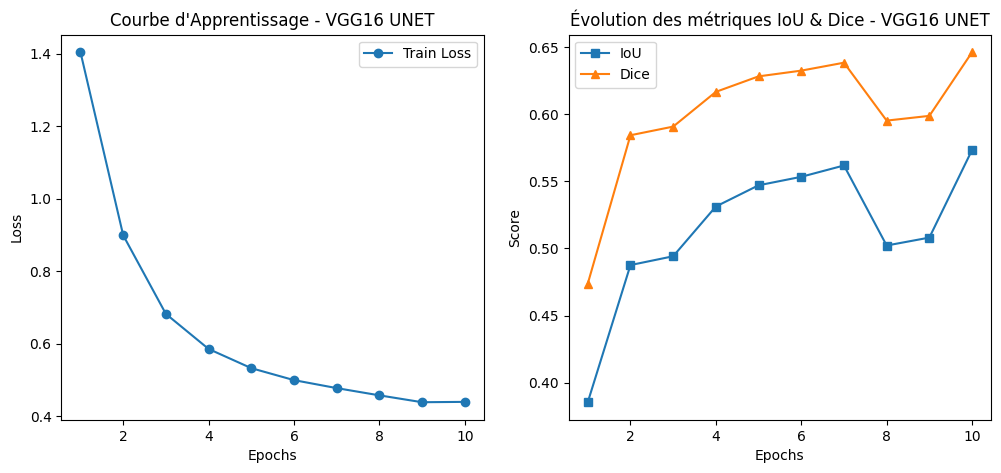

In [61]:
# Tracer la courbe d'apprentissage
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Courbe d'Apprentissage - VGG16 UNET")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), test_iou_scores, label="IoU", marker='s')
plt.plot(range(1, num_epochs + 1), test_dice_scores, label="Dice", marker='^')
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.title("Évolution des métriques IoU & Dice - VGG16 UNET")
plt.legend()
plt.show()

# Sauvegarde des métriques
with open("training_metrics_vgg16unet.pkl", "wb") as f:
    pickle.dump({
        "train_losses": train_losses, 
        "test_iou_scores": test_iou_scores, 
        "test_dice_scores": test_dice_scores
    }, f)

In [79]:
# Sauvegardez le modèle après l'entraînement
save_model(model, path="vgg16_sda_model.pth")

Modèle sauvegardé à vgg16_sda_model.pth


### 3 - VGG16-UNet pré-entrainé


In [76]:
class VGG16UNET_preent(nn.Module):
    def __init__(self, n_channels=3, n_classes=8):
        super(VGG16UNET_preent, self).__init__()

        # Utiliser un VGG16 pré-entraîné comme encodeur
        vgg16 = models.vgg16(pretrained=True)

        self.n_channels = n_channels
        self.n_classes = n_classes

        # Encoder (features de VGG16)
        self.inc = nn.Sequential(*list(vgg16.features.children())[:4])    # 64 canaux
        self.down1 = nn.Sequential(*list(vgg16.features.children())[4:9])  # 128 canaux
        self.down2 = nn.Sequential(*list(vgg16.features.children())[9:16])  # 256 canaux
        self.down3 = nn.Sequential(*list(vgg16.features.children())[16:23])  # 512 canaux

        # Decoder
        self.up1 = Up(512, 256)   # Concaténation des features de down2 et down3
        self.up2 = Up(256, 128)   # Concaténation des features de down1 et up1
        self.up3 = Up(128, 64)    # Concaténation des features de inc et up2

        # Couche de sortie
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        # Encoder
        x1 = self.inc(x)       # 64 canaux
        x2 = self.down1(x1)    # 128 canaux
        x3 = self.down2(x2)    # 256 canaux
        x4 = self.down3(x3)    # 512 canaux

        # Decoder avec skip connections
        x = self.up1(x4, x3)   # 256 canaux
        x = self.up2(x, x2)    # 128 canaux
        x = self.up3(x, x1)    # 64 canaux

        return self.outc(x)    # n_classes canaux

In [77]:
# Instancier le nouveau modèle
model = VGG16UNET_preent(n_channels=3, n_classes=8)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Stockage des métriques
train_losses = []
test_iou_scores = []
test_dice_scores = []

# Boucle d'entraînement
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    
    for images, masks in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{num_epochs}"):
        if masks.dim() == 4 and masks.size(1) == 1:
            masks = masks.squeeze(1)
        masks = masks.long()
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    train_losses.append(epoch_loss / len(train_loader))  # Stockage de la perte
    
    # Évaluation
    model.eval()
    iou_scores = []
    dice_scores = []
    with torch.no_grad():
        for images, masks in test_loader:
            if masks.dim() == 4 and masks.size(1) == 1:
                masks = masks.squeeze(1)
            masks = masks.long()
            
            outputs = model(images)
            iou = calculate_iou(outputs, masks, num_classes=8)
            dice = calculate_dice_coefficient(outputs, masks, num_classes=8)
            
            iou_scores.append(iou)
            dice_scores.append(dice)
        
        mean_iou = sum(iou_scores) / len(iou_scores)
        mean_dice = sum(dice_scores) / len(dice_scores)
        
        test_iou_scores.append(mean_iou)  # Stockage des métriques
        test_dice_scores.append(mean_dice)
        
        print(f"Epoch {epoch + 1}, Test IoU: {mean_iou:.4f}, Test Dice: {mean_dice:.4f}")

Training Epoch 1/10: 100%|██████████| 72/72 [25:28<00:00, 21.24s/it] 


Epoch 1, Test IoU: 0.5211, Test Dice: 0.6092


Training Epoch 2/10: 100%|██████████| 72/72 [28:05<00:00, 23.41s/it]


Epoch 2, Test IoU: 0.5864, Test Dice: 0.6733


Training Epoch 3/10: 100%|██████████| 72/72 [34:25<00:00, 28.69s/it]


Epoch 3, Test IoU: 0.6362, Test Dice: 0.7302


Training Epoch 4/10: 100%|██████████| 72/72 [34:38<00:00, 28.87s/it]


Epoch 4, Test IoU: 0.6129, Test Dice: 0.7243


Training Epoch 5/10: 100%|██████████| 72/72 [34:44<00:00, 28.95s/it]


Epoch 5, Test IoU: 0.6829, Test Dice: 0.7826


Training Epoch 6/10: 100%|██████████| 72/72 [34:50<00:00, 29.03s/it]


Epoch 6, Test IoU: 0.6448, Test Dice: 0.7517


Training Epoch 7/10: 100%|██████████| 72/72 [34:27<00:00, 28.71s/it]


Epoch 7, Test IoU: 0.6947, Test Dice: 0.7967


Training Epoch 8/10: 100%|██████████| 72/72 [34:39<00:00, 28.88s/it]


Epoch 8, Test IoU: 0.7127, Test Dice: 0.8113


Training Epoch 9/10: 100%|██████████| 72/72 [34:41<00:00, 28.91s/it]


Epoch 9, Test IoU: 0.6980, Test Dice: 0.7988


Training Epoch 10/10: 100%|██████████| 72/72 [34:41<00:00, 28.92s/it]


Epoch 10, Test IoU: 0.7049, Test Dice: 0.8035


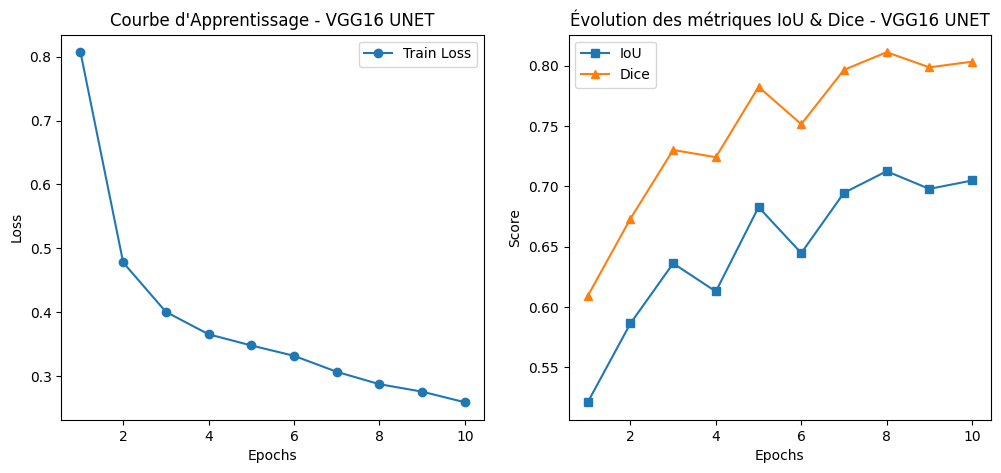

In [78]:
# Tracer la courbe d'apprentissage
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Courbe d'Apprentissage - VGG16 UNET")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), test_iou_scores, label="IoU", marker='s')
plt.plot(range(1, num_epochs + 1), test_dice_scores, label="Dice", marker='^')
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.title("Évolution des métriques IoU & Dice - VGG16 UNET")
plt.legend()
plt.show()

# Sauvegarde des métriques
with open("training_metrics_vgg16unet_preent.pkl", "wb") as f:
    pickle.dump({
        "train_losses": train_losses, 
        "test_iou_scores": test_iou_scores, 
        "test_dice_scores": test_dice_scores
    }, f)

In [80]:
# Sauvegardez le modèle après l'entraînement
save_model(model, path="vgg16_preent_sda_model.pth")

Modèle sauvegardé à vgg16_preent_sda_model.pth


## Annexes

Attention: Le masque de aachen contient des valeurs inattendues: [  0  14  38  52  75  89 113 128]
Attention: Le masque de bochum contient des valeurs inattendues: [  0  14  38  52  75  89 113 128]
Attention: Le masque de bremen contient des valeurs inattendues: [  0  14  38  52  75  89 113 128]
Attention: Le masque de cologne contient des valeurs inattendues: [  0  14  38  52  75  89 113 128]
Attention: Le masque de darmstadt contient des valeurs inattendues: [  0  14  38  52  75  89 113 128]
Attention: Le masque de dusseldorf contient des valeurs inattendues: [  0  14  38  52  75  89 113 128]
Attention: Le masque de erfurt contient des valeurs inattendues: [  0  14  38  52  75  89 113 128]
Attention: Le masque de hamburg contient des valeurs inattendues: [  0  14  38  52  75  89 113 128]
Attention: Le masque de hanover contient des valeurs inattendues: [  0  14  38  52  75  89 113 128]
Attention: Le masque de jena contient des valeurs inattendues: [  0  14  38  52  75  89 113 128]
At

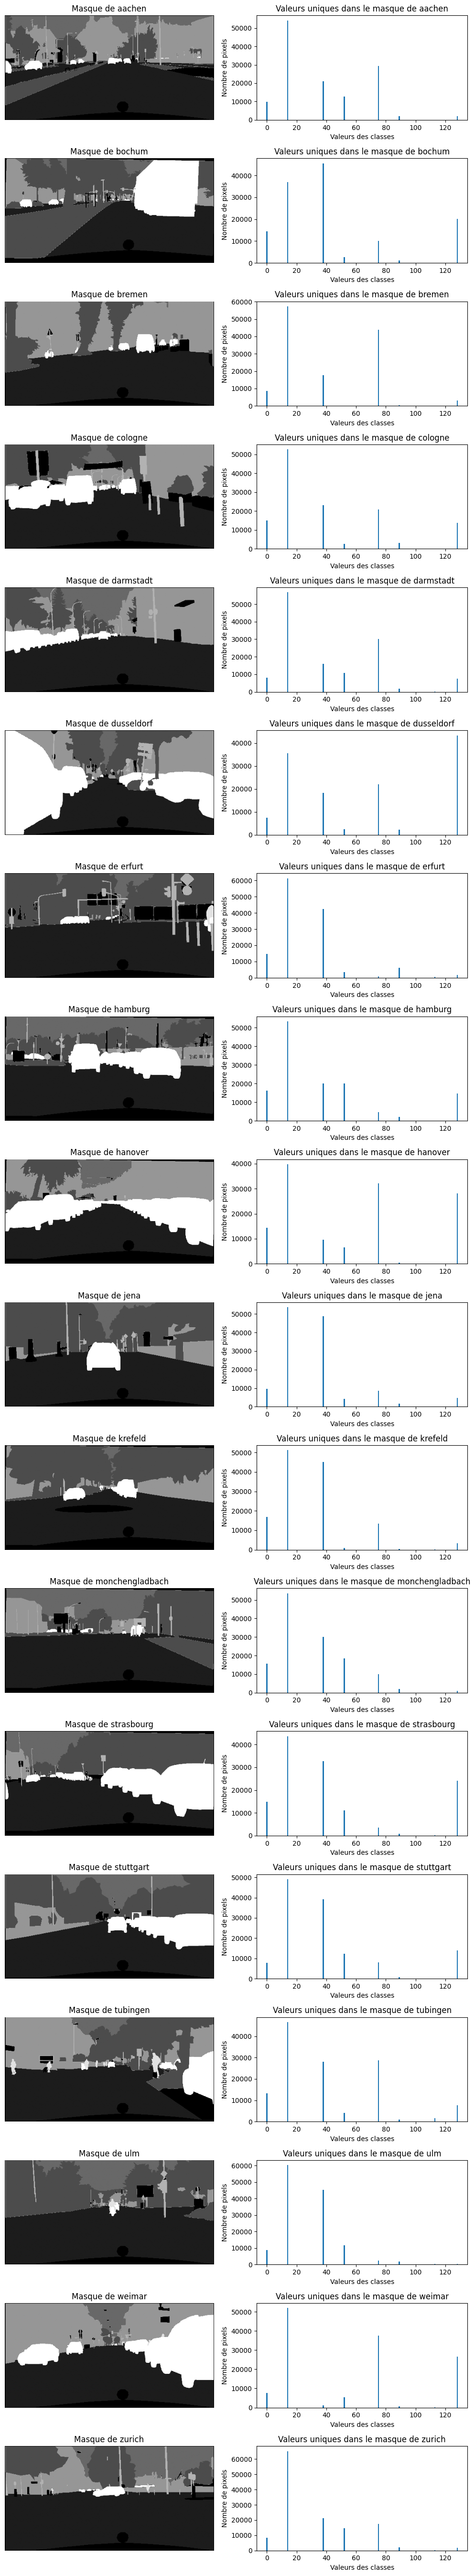

In [11]:
# Chemins vers les dossiers contenant les images et les masques
chemin_original = "../Echantillons_redim/Original"
chemin_categorie = "../Echantillons_redim/Image_annote_categorie"

# Liste des villes
villes = os.listdir(chemin_original)

# Fonction pour afficher les masques et vérifier les valeurs uniques
def verifier_masques(chemin_categorie, villes, num_classes=8):
    fig, axes = plt.subplots(len(villes), 2, figsize=(10, len(villes) * 3))

    for i, ville in enumerate(villes):
        masques_path = os.path.join(chemin_categorie, ville)
        masques_files = os.listdir(masques_path)

        # Charger un masque aléatoire pour chaque ville
        masque_path = os.path.join(masques_path, masques_files[0])
        masque = cv2.imread(masque_path, cv2.IMREAD_GRAYSCALE)

        # Afficher le masque
        axes[i, 0].imshow(masque, cmap='gray')
        axes[i, 0].set_title(f"Masque de {ville}")
        axes[i, 0].axis('off')

        # Vérifier les valeurs uniques dans le masque
        unique_values = np.unique(masque)
        axes[i, 1].bar(unique_values, [np.sum(masque == value) for value in unique_values])
        axes[i, 1].set_title(f"Valeurs uniques dans le masque de {ville}")
        axes[i, 1].set_xlabel("Valeurs des classes")
        axes[i, 1].set_ylabel("Nombre de pixels")

        # Vérifier que les valeurs uniques sont dans la plage attendue
        if not np.all(unique_values < num_classes):
            print(f"Attention: Le masque de {ville} contient des valeurs inattendues: {unique_values}")

    plt.tight_layout()
    plt.show()

# Vérifier les masques
verifier_masques(chemin_categorie, villes)


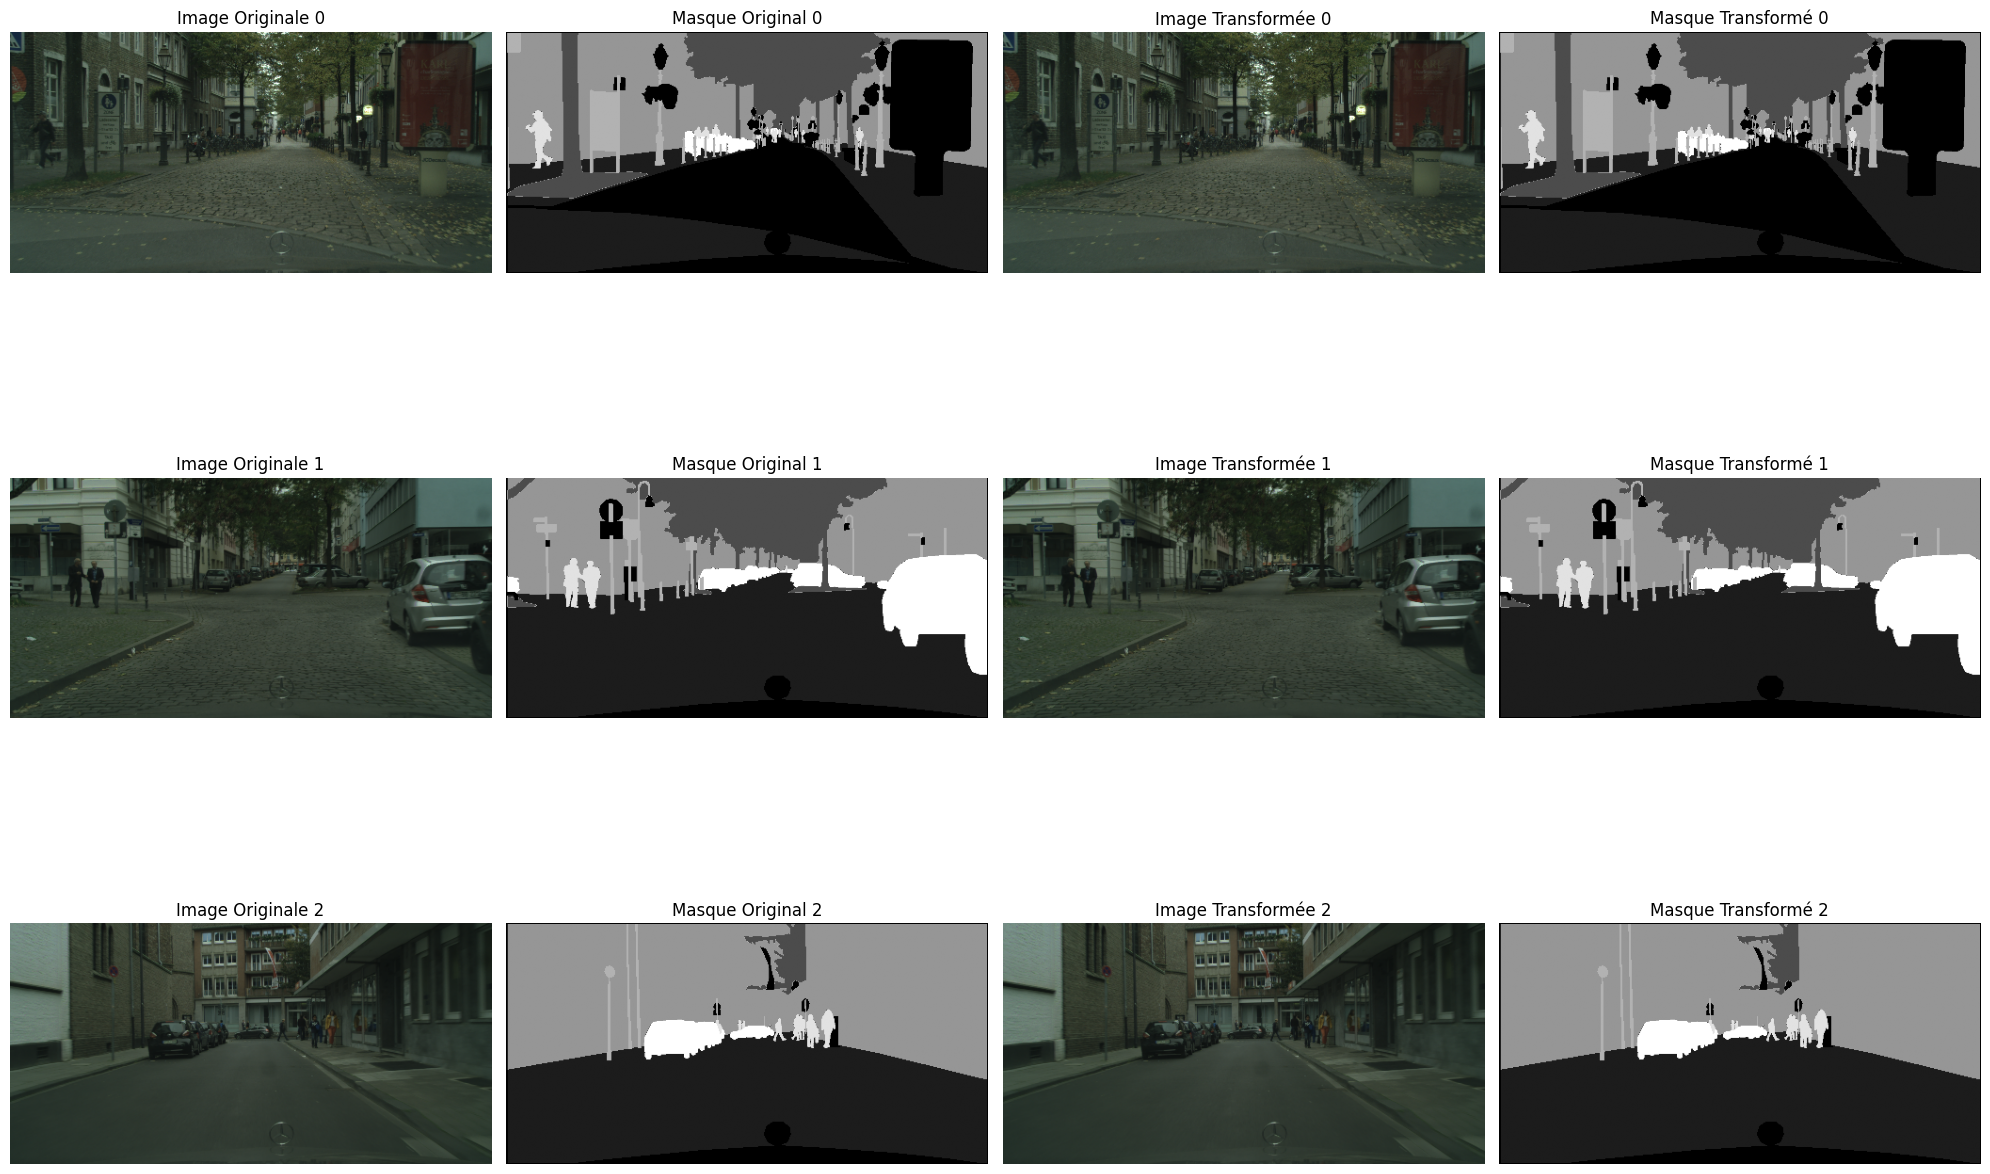

In [16]:
import matplotlib.pyplot as plt
import cv2
import torchvision.transforms as transforms

# Fonction pour afficher les images et masques avant et après transformation
def afficher_transformations(image_paths, mask_paths, image_transform, mask_transform, indices=[0, 1, 2]):
    fig, axes = plt.subplots(len(indices), 4, figsize=(20, 5 * len(indices)))

    for i, idx in enumerate(indices):
        # Charger l'image et le masque originaux
        image = cv2.imread(image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convertir en RGB
        mask = cv2.imread(mask_paths[idx], cv2.IMREAD_GRAYSCALE)  # Lire le masque en niveaux de gris

        # Afficher l'image et le masque originaux
        axes[i, 0].imshow(image)
        axes[i, 0].set_title(f"Image Originale {idx}")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(mask, cmap='gray')
        axes[i, 1].set_title(f"Masque Original {idx}")
        axes[i, 1].axis('off')

        # Appliquer les transformations
        image_transformed = image_transform(image)
        mask_transformed = mask_transform(mask)

        # Afficher l'image et le masque transformés
        axes[i, 2].imshow(image_transformed.permute(1, 2, 0).numpy())
        axes[i, 2].set_title(f"Image Transformée {idx}")
        axes[i, 2].axis('off')

        axes[i, 3].imshow(mask_transformed.squeeze().numpy(), cmap='gray')
        axes[i, 3].set_title(f"Masque Transformé {idx}")
        axes[i, 3].axis('off')

    plt.tight_layout()
    plt.show()

# Afficher les transformations pour quelques exemples
afficher_transformations(train_images, train_masks, image_transform, mask_transform)
